### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [2]:
# Set device to cuda
device = torch.device('cuda:0')

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """
        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug: 
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


### Submodules

Here are the Encoders, Decoder, and LSTM

In [3]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D) 
        """
        return self.linear_layer(x[-1])
    
class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)
    
class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=32, out_channels=1, in_dim=512, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),  # (B, 5, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 5, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 32, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 16, 256, 256)
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.decoder(x.permute(1, 0, 2))
    

# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): # or nn.ReLU
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64 # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)
        return x  # (T, B, hidden_dim)

# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [4]:
# Test conv encoder
mock_img_data = torch.zeros((5, 16, 1, 256, 256))
img_encoder = CNNEncoder()
img_embedding = img_encoder(mock_img_data)

# Test state encoder
mock_state_data = torch.zeros((5,64, 13))
state_encoder = JStateEncoder()
state_embedding = state_encoder(mock_state_data)


In [5]:
img_embedding.shape
# state_embedding.shape

torch.Size([5, 16, 1024])

In [6]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]

# Jialin's LSTM
class JLSTM(nn.Module):
    '''
    LSTM with the image + pose embeddings as input
    '''
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=False,
            bidirectional=False
        )

    def forward(self, x):  # (T, B, input_dim)
        out, _ = self.lstm(x)
        return out  # (T, B, hidden_dim)
    

class MLP(nn.Module): 
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()
        
        ### Create model 
        out_dim = hidden_dim 
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers): 
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers) 
        
    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D) 
        """
        x = x
        return self.model(x).unsqueeze(0)


In [7]:
# Loss functions 
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [8]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512, seq_length=5, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        # Jialin Modules
        # self.image_encoder = CNNEncoder()
        # self.state_encoder = JStateEncoder()
        # self.lstm = JLSTM(input_dim=in_dim, hidden_dim=hidden_dim)
        # self.image_decoder = ImgDecoder()
        # self.loss_fun = nn.MSELoss()

        # Juan Modules 
        self.image_encoder = ImgEncoder()
        self.state_encoder = StateEncoder() 
        self.lstm = MLP(in_dim, hidden_dim) 
        self.image_decoder = ImgDecoder2(in_channels=1, in_dim=1024) # in_channels should be 5 for lstm
        self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4)[-1, ...] #(T, B, 1, H, W) --> (B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frame = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frame, out_frame), pred_frame


In [9]:
### Test FilterNet

# # Generate mock input
# mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
# mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
# mock_state_data = torch.zeros((16, 5, 13), device=device)
# datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# # Initialize model
# filternet = FilterNet().to(device)

# # Test loss function
# out = filternet.loss(datapoint)
# out


### Traning Loop

In [10]:
# Define training parameters
num_epochs = 100 # originally 10
num_workers = 2
num_vids = 7 
path_to_data = 'processed_flow'
augmented = False
batch_size = 16
seq_length = 5
img_size = 256


# because mac :)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize model
model = FilterNet(hidden_dim=1024)
model = model.to(device) # added

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr = 0.001

# next(model.parameters()).device



100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


In [11]:
# Training loop
import torchvision 
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device
        frames, state = sequence['input']
        out_frame = sequence['target']

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        B, T, C, H, W = frames.shape
        nonzero_mask = frames.view(B, -1).any(dim=1)
        frames = frames[nonzero_mask]
        out_frame = out_frame[nonzero_mask] 
        state = state[nonzero_mask]

        sequence['input'] = (frames.to(device), state.to(device))
        sequence['target'] = out_frame.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(sequence)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % 250 == 249: # report loss every 1000 batches
            last_loss = running_loss / 250 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            with torch.no_grad():
                print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')
        

        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches

    print(f'Epoch {epoch + 1} average loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches



Epoch 1/100:


250it [02:19,  2.05it/s]

 batch 250 loss: 0.833404439330101
Prediction logit mean: -1.692728877067566, std: 2.3330559730529785, and max: 1.9965333938598633 and min: -17.029705047607422


500it [04:38,  2.05it/s]

 batch 500 loss: 0.7341450064182281
Prediction logit mean: -4.299077033996582, std: 4.758029937744141, and max: 1.9374377727508545 and min: -60.22166442871094


750it [06:58,  2.07it/s]

 batch 750 loss: 0.7180924754142761
Prediction logit mean: -3.2980244159698486, std: 4.76328706741333, and max: 13.991250038146973 and min: -58.999176025390625


1000it [09:17,  2.06it/s]

 batch 1000 loss: 0.7002586189508438
Prediction logit mean: -6.2755126953125, std: 9.274267196655273, and max: 0.8304598331451416 and min: -134.85987854003906


1068it [09:54,  1.80it/s]

Epoch 1 average loss: 0.7450196726268596

Epoch 2/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.6763899759054184
Prediction logit mean: -3.795640707015991, std: 4.885392665863037, and max: 19.770469665527344 and min: -96.26517486572266


500it [04:37,  2.05it/s]

 batch 500 loss: 0.6697264055013656
Prediction logit mean: -4.994443893432617, std: 6.749283313751221, and max: 1.1417993307113647 and min: -84.39542388916016


750it [06:56,  2.07it/s]

 batch 750 loss: 0.6715115729570389
Prediction logit mean: -2.6092560291290283, std: 3.990022659301758, and max: 4.145562171936035 and min: -74.93270111083984


1000it [09:15,  2.07it/s]

 batch 1000 loss: 0.6784802651405335
Prediction logit mean: -9.491588592529297, std: 16.010257720947266, and max: 1.284581184387207 and min: -315.2353820800781


1068it [09:52,  1.80it/s]

Epoch 2 average loss: 0.6713743954896927

Epoch 3/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.6320785270929337
Prediction logit mean: -13.447562217712402, std: 17.546735763549805, and max: 1.301766037940979 and min: -393.89202880859375


500it [04:37,  2.07it/s]

 batch 500 loss: 0.6075371500253678
Prediction logit mean: -13.78130054473877, std: 13.348771095275879, and max: 4.656385898590088 and min: -119.1917724609375


750it [06:56,  2.06it/s]

 batch 750 loss: 0.5908324267864228
Prediction logit mean: -6.447677135467529, std: 9.231795310974121, and max: 3.5780797004699707 and min: -151.92514038085938


1000it [09:15,  2.09it/s]

 batch 1000 loss: 0.6003959819078445
Prediction logit mean: -9.047861099243164, std: 11.356949806213379, and max: 1.5501327514648438 and min: -128.1051483154297


1068it [09:53,  1.80it/s]

Epoch 3 average loss: 0.605881226699004

Epoch 4/100:



250it [02:18,  2.07it/s]

 batch 250 loss: 0.5708489260673523
Prediction logit mean: -15.405962944030762, std: 20.680639266967773, and max: 2.442807912826538 and min: -432.53070068359375


500it [04:37,  2.06it/s]

 batch 500 loss: 0.5607819546461106
Prediction logit mean: -19.950273513793945, std: 21.580778121948242, and max: 1.9455350637435913 and min: -323.9053649902344


750it [06:56,  2.06it/s]

 batch 750 loss: 0.5479861447811126
Prediction logit mean: -19.801549911499023, std: 22.338592529296875, and max: 8.277803421020508 and min: -185.26072692871094


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.5557717201709748
Prediction logit mean: -14.13538646697998, std: 18.448759078979492, and max: 2.3805062770843506 and min: -338.5700988769531


1068it [09:52,  1.80it/s]


Epoch 4 average loss: 0.5594453996654307

Epoch 5/100:


250it [02:19,  1.94it/s]

 batch 250 loss: 0.5266647295951843
Prediction logit mean: -19.465810775756836, std: 19.310897827148438, and max: 7.69090461730957 and min: -291.03851318359375


500it [04:38,  1.71it/s]

 batch 500 loss: 0.5608322376012802
Prediction logit mean: -22.42761993408203, std: 27.67396354675293, and max: 20.951051712036133 and min: -447.9366149902344


751it [06:57,  2.07it/s]

 batch 750 loss: 0.54511063849926
Prediction logit mean: -25.53277587890625, std: 35.494651794433594, and max: 10.905614852905273 and min: -1080.14697265625


1001it [09:15,  2.03it/s]

 batch 1000 loss: 0.5095736111402511
Prediction logit mean: -10.995828628540039, std: 11.933752059936523, and max: 15.832073211669922 and min: -222.95452880859375


1068it [09:52,  1.80it/s]

Epoch 5 average loss: 0.5328319426835253

Epoch 6/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.5018228240013123
Prediction logit mean: -21.822229385375977, std: 26.05326271057129, and max: 4.642673492431641 and min: -389.7054443359375


500it [04:37,  2.10it/s]

 batch 500 loss: 0.5181653673648834
Prediction logit mean: -17.126976013183594, std: 21.387615203857422, and max: 4.322495460510254 and min: -464.6175537109375


750it [06:57,  2.08it/s]

 batch 750 loss: 0.5080851637125016
Prediction logit mean: -18.731687545776367, std: 21.782527923583984, and max: 2.157637596130371 and min: -523.3338012695312


1000it [09:15,  2.08it/s]

 batch 1000 loss: 0.5281581226587295
Prediction logit mean: -14.033638000488281, std: 15.310114860534668, and max: 2.2895777225494385 and min: -300.19549560546875


1068it [09:53,  1.80it/s]

Epoch 6 average loss: 0.5140530113479618

Epoch 7/100:



250it [02:19,  2.07it/s]

 batch 250 loss: 0.49321129989624024
Prediction logit mean: -16.819814682006836, std: 20.23393440246582, and max: 8.138728141784668 and min: -532.4442138671875


500it [04:37,  2.07it/s]

 batch 500 loss: 0.499478312253952
Prediction logit mean: -22.88843536376953, std: 27.977386474609375, and max: 2.082009792327881 and min: -847.3491821289062


750it [06:56,  2.03it/s]

 batch 750 loss: 0.49745694470405577
Prediction logit mean: -18.30448341369629, std: 20.36491584777832, and max: 5.996378421783447 and min: -388.5164794921875


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.49475124216079713
Prediction logit mean: -10.262667655944824, std: 16.304555892944336, and max: 2.7717397212982178 and min: -361.73236083984375


1068it [09:52,  1.80it/s]

Epoch 7 average loss: 0.49462031874428974

Epoch 8/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.49740695118904116
Prediction logit mean: -26.152252197265625, std: 29.956897735595703, and max: 2.063037395477295 and min: -886.509765625


500it [04:37,  2.12it/s]

 batch 500 loss: 0.47945599007606504
Prediction logit mean: -5.211387634277344, std: 9.307400703430176, and max: 4.18529748916626 and min: -458.484619140625


750it [06:55,  2.08it/s]

 batch 750 loss: 0.5187469907999038
Prediction logit mean: -22.476543426513672, std: 29.98450469970703, and max: 2.987095832824707 and min: -389.5086364746094


1000it [09:14,  2.07it/s]

 batch 1000 loss: 0.4572279098033905
Prediction logit mean: -15.914958000183105, std: 17.859756469726562, and max: 3.6010360717773438 and min: -297.0381164550781


1068it [09:52,  1.80it/s]

Epoch 8 average loss: 0.4892588397313593

Epoch 9/100:



250it [02:18,  2.03it/s]

 batch 250 loss: 0.46438505351543424
Prediction logit mean: -23.626224517822266, std: 25.07625961303711, and max: 13.742605209350586 and min: -727.42333984375


500it [04:37,  2.01it/s]

 batch 500 loss: 0.4737257808446884
Prediction logit mean: -13.701958656311035, std: 15.02776050567627, and max: 2.428791046142578 and min: -286.3615417480469


750it [06:56,  2.06it/s]

 batch 750 loss: 0.45359282982349397
Prediction logit mean: -8.588582992553711, std: 11.647404670715332, and max: 4.918244361877441 and min: -322.3847961425781


1000it [09:15,  2.07it/s]

 batch 1000 loss: 0.46024960935115816
Prediction logit mean: -37.54346466064453, std: 41.48664855957031, and max: 2.5034544467926025 and min: -636.9571533203125


1068it [09:52,  1.80it/s]

Epoch 9 average loss: 0.4610683231262232

Epoch 10/100:



250it [02:18,  2.03it/s]

 batch 250 loss: 0.4420716310739517
Prediction logit mean: -28.915849685668945, std: 34.141387939453125, and max: 2.522822856903076 and min: -587.9160766601562


500it [04:37,  2.06it/s]

 batch 500 loss: 0.44096949124336243
Prediction logit mean: -33.365779876708984, std: 35.877315521240234, and max: 3.7755448818206787 and min: -755.3626708984375


750it [06:56,  2.07it/s]

 batch 750 loss: 0.43875522661209104
Prediction logit mean: -12.46860122680664, std: 15.057931900024414, and max: 4.307553291320801 and min: -529.39697265625


1000it [09:15,  2.09it/s]

 batch 1000 loss: 0.443436460852623
Prediction logit mean: -65.05022430419922, std: 74.70655822753906, and max: 2.6556882858276367 and min: -795.02294921875


1068it [09:52,  1.80it/s]

Epoch 10 average loss: 0.4406399481305469

Epoch 11/100:



250it [02:19,  2.03it/s]

 batch 250 loss: 0.43470436084270475
Prediction logit mean: -49.266334533691406, std: 52.74150848388672, and max: 2.8073158264160156 and min: -1070.51708984375


500it [04:37,  2.06it/s]

 batch 500 loss: 0.4367163451910019
Prediction logit mean: -50.92333221435547, std: 52.83633041381836, and max: 2.5202581882476807 and min: -704.699951171875


750it [06:56,  2.07it/s]

 batch 750 loss: 0.42105889081954956
Prediction logit mean: -31.469633102416992, std: 36.24270248413086, and max: 63.55207061767578 and min: -1108.181640625


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.4665090777873993
Prediction logit mean: -25.827709197998047, std: 29.46369743347168, and max: 2.7229859828948975 and min: -844.3953857421875


1068it [09:52,  1.80it/s]

Epoch 11 average loss: 0.43938925513502364

Epoch 12/100:



250it [02:19,  2.07it/s]

 batch 250 loss: 0.4080898098945618
Prediction logit mean: -32.31790542602539, std: 31.818248748779297, and max: 2.6952168941497803 and min: -470.63385009765625


500it [04:38,  2.05it/s]

 batch 500 loss: 0.4130380244255066
Prediction logit mean: -57.130123138427734, std: 54.381832122802734, and max: 2.953838348388672 and min: -749.1580810546875


750it [06:56,  2.09it/s]

 batch 750 loss: 0.42670272731781006
Prediction logit mean: -28.57042121887207, std: 33.56453323364258, and max: 2.8514904975891113 and min: -369.4200744628906


1000it [09:15,  2.06it/s]

 batch 1000 loss: 0.451952586889267
Prediction logit mean: -7.768725872039795, std: 9.93703556060791, and max: 4.437968730926514 and min: -327.1575927734375


1068it [09:52,  1.80it/s]

Epoch 12 average loss: 0.4277345716171943

Epoch 13/100:



250it [02:19,  2.04it/s]

 batch 250 loss: 0.4310566074848175
Prediction logit mean: -45.86183547973633, std: 43.67521667480469, and max: 2.8858184814453125 and min: -472.9788818359375


500it [04:37,  2.08it/s]

 batch 500 loss: 0.4151686532497406
Prediction logit mean: -76.06588745117188, std: 71.72832489013672, and max: 2.466337203979492 and min: -675.2513427734375


750it [06:56,  2.07it/s]

 batch 750 loss: 0.4193926032781601
Prediction logit mean: -29.717700958251953, std: 33.00101089477539, and max: 2.815445899963379 and min: -386.3394775390625


1000it [09:14,  2.03it/s]

 batch 1000 loss: 0.39888450133800507
Prediction logit mean: -41.22869873046875, std: 53.476280212402344, and max: 2.9353415966033936 and min: -777.0963134765625


1068it [09:52,  1.80it/s]

Epoch 13 average loss: 0.4183390181553498

Epoch 14/100:



250it [02:18,  2.02it/s]

 batch 250 loss: 0.42459466004371643
Prediction logit mean: -52.97382736206055, std: 50.72796630859375, and max: 2.931839942932129 and min: -625.11962890625


500it [04:37,  2.04it/s]

 batch 500 loss: 0.4097186231613159
Prediction logit mean: -35.00898742675781, std: 29.27863121032715, and max: 2.688347816467285 and min: -282.52239990234375


750it [06:55,  2.03it/s]

 batch 750 loss: 0.41108693861961365
Prediction logit mean: -42.105133056640625, std: 45.90196990966797, and max: 2.89847993850708 and min: -553.515625


1000it [09:14,  1.97it/s]

 batch 1000 loss: 0.3994873037338257
Prediction logit mean: -26.158897399902344, std: 27.102415084838867, and max: 2.9302053451538086 and min: -336.1280517578125


1068it [09:52,  1.80it/s]

Epoch 14 average loss: 0.4116494105047501

Epoch 15/100:



250it [02:18,  2.10it/s]

 batch 250 loss: 0.4363511164188385
Prediction logit mean: -20.82667350769043, std: 22.094284057617188, and max: 2.698357582092285 and min: -344.5994873046875


500it [04:37,  1.91it/s]

 batch 500 loss: 0.43566760742664334
Prediction logit mean: -29.084264755249023, std: 28.390316009521484, and max: 2.6811678409576416 and min: -279.7950134277344


750it [06:56,  1.86it/s]

 batch 750 loss: 0.3986908860206604
Prediction logit mean: -50.75390625, std: 50.18954086303711, and max: 2.9191763401031494 and min: -687.2542114257812


1000it [09:15,  2.06it/s]

 batch 1000 loss: 0.39594048738479615
Prediction logit mean: -29.896625518798828, std: 33.06550979614258, and max: 2.756261110305786 and min: -477.7490539550781


1068it [09:53,  1.80it/s]

Epoch 15 average loss: 0.41653520334860805

Epoch 16/100:



250it [02:18,  2.12it/s]

 batch 250 loss: 0.39527565133571624
Prediction logit mean: -22.99120330810547, std: 19.34668731689453, and max: 3.245757579803467 and min: -170.11477661132812


500it [04:37,  2.08it/s]

 batch 500 loss: 0.3921675686836243
Prediction logit mean: -54.75834274291992, std: 51.365234375, and max: 2.9700701236724854 and min: -517.796875


750it [06:56,  2.03it/s]

 batch 750 loss: 0.3897681163549423
Prediction logit mean: -82.87984466552734, std: 79.06385803222656, and max: 3.036606788635254 and min: -990.256103515625


1000it [09:14,  2.05it/s]

 batch 1000 loss: 0.3845447425842285
Prediction logit mean: -66.91326904296875, std: 63.62333679199219, and max: 2.8348212242126465 and min: -709.8675537109375


1068it [09:52,  1.80it/s]

Epoch 16 average loss: 0.39205583254719495

Epoch 17/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.49039072608947754
Prediction logit mean: -21.025081634521484, std: 26.035400390625, and max: 2.9484214782714844 and min: -284.5629577636719


500it [04:37,  2.07it/s]

 batch 500 loss: 0.40208368122577665
Prediction logit mean: -34.53844451904297, std: 42.822933197021484, and max: 3.1914055347442627 and min: -495.9368896484375


750it [06:56,  2.08it/s]

 batch 750 loss: 0.41109390604496004
Prediction logit mean: -41.762413024902344, std: 52.05860900878906, and max: 2.947352886199951 and min: -711.3460693359375


1000it [09:15,  2.03it/s]

 batch 1000 loss: 0.40661596167087555
Prediction logit mean: -37.41713333129883, std: 54.76563262939453, and max: 3.0733089447021484 and min: -785.791748046875


1068it [09:52,  1.80it/s]

Epoch 17 average loss: 0.42469577948922077

Epoch 18/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.37260525941848754
Prediction logit mean: -43.472381591796875, std: 42.89236831665039, and max: 3.0837392807006836 and min: -565.0482177734375


500it [04:38,  1.93it/s]

 batch 500 loss: 0.3637463072538376
Prediction logit mean: -45.590335845947266, std: 41.77909469604492, and max: 3.290593147277832 and min: -538.0004272460938


750it [06:57,  1.70it/s]

 batch 750 loss: 0.3976970765590668
Prediction logit mean: -58.46443557739258, std: 56.20667266845703, and max: 3.0564332008361816 and min: -727.3955688476562


1000it [09:15,  1.77it/s]

 batch 1000 loss: 0.4051028189063072
Prediction logit mean: -38.12440872192383, std: 41.3870849609375, and max: 3.3010330200195312 and min: -585.4757690429688


1068it [09:53,  1.80it/s]

Epoch 18 average loss: 0.3870336270650451

Epoch 19/100:



250it [02:19,  2.10it/s]

 batch 250 loss: 0.41728203690052035
Prediction logit mean: -50.55553436279297, std: 53.685970306396484, and max: 3.904635429382324 and min: -788.953857421875


500it [04:37,  2.02it/s]

 batch 500 loss: 0.4388409334421158
Prediction logit mean: -72.26171875, std: 70.80066680908203, and max: 2.7739720344543457 and min: -922.9690551757812


750it [06:56,  2.05it/s]

 batch 750 loss: 0.389618035197258
Prediction logit mean: -26.3769474029541, std: 27.60492515563965, and max: 3.0405335426330566 and min: -364.8326110839844


1000it [09:15,  1.86it/s]

 batch 1000 loss: 0.4050768052339554
Prediction logit mean: -40.173465728759766, std: 38.32020950317383, and max: 2.784947395324707 and min: -432.5227966308594


1068it [09:53,  1.80it/s]

Epoch 19 average loss: 0.411354069629412

Epoch 20/100:



250it [02:19,  2.02it/s]

 batch 250 loss: 0.4180461802482605
Prediction logit mean: -49.62853240966797, std: 47.9621467590332, and max: 3.0491080284118652 and min: -557.8380737304688


500it [04:37,  2.09it/s]

 batch 500 loss: 0.46761040651798247
Prediction logit mean: -26.073978424072266, std: 25.685749053955078, and max: 3.0653204917907715 and min: -274.08514404296875


750it [06:56,  2.04it/s]

 batch 750 loss: 0.3951277928352356
Prediction logit mean: -64.1534423828125, std: 70.0049819946289, and max: 3.1667397022247314 and min: -818.7345581054688


1000it [09:15,  1.68it/s]

 batch 1000 loss: 0.45251091837882995
Prediction logit mean: -21.514257431030273, std: 24.620058059692383, and max: 2.912641763687134 and min: -288.419677734375


1068it [09:52,  1.80it/s]

Epoch 20 average loss: 0.4360487184274509

Epoch 21/100:



250it [02:19,  2.05it/s]

 batch 250 loss: 0.4254848829507828
Prediction logit mean: -11.278881072998047, std: 12.125469207763672, and max: 2.857354164123535 and min: -133.29061889648438


500it [04:37,  2.10it/s]

 batch 500 loss: 0.643934251666069
Prediction logit mean: -1.641638994216919, std: 0.6512055397033691, and max: 2.856020450592041 and min: -1.761163353919983


750it [06:56,  2.06it/s]

 batch 750 loss: 0.8906927082538605
Prediction logit mean: -0.983490526676178, std: 0.14340700209140778, and max: 2.4263739585876465 and min: -0.9985827207565308


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.9004191262722016
Prediction logit mean: -0.8493449091911316, std: 0.1647009253501892, and max: 2.856996774673462 and min: -0.8657174110412598


1068it [09:52,  1.80it/s]

Epoch 21 average loss: 0.7271752174427447

Epoch 22/100:



250it [02:19,  2.05it/s]

 batch 250 loss: 0.9137521691322327
Prediction logit mean: -0.8124079704284668, std: 0.22002990543842316, and max: 3.088048219680786 and min: -0.8365362882614136


500it [04:37,  2.07it/s]

 batch 500 loss: 0.8961494297981262
Prediction logit mean: -0.7510038614273071, std: 0.19180811941623688, and max: 3.806734800338745 and min: -0.7706341743469238


750it [06:56,  2.05it/s]

 batch 750 loss: 0.8831513679027557
Prediction logit mean: -0.8512822985649109, std: 0.17701862752437592, and max: 3.441786766052246 and min: -0.8699873685836792


1000it [09:15,  2.10it/s]

 batch 1000 loss: 0.8255913299322128
Prediction logit mean: -1.2070670127868652, std: 0.2990524470806122, and max: 4.658548831939697 and min: -1.240413784980774


1068it [09:52,  1.80it/s]

Epoch 22 average loss: 0.8772584944126312

Epoch 23/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.8549587454795837
Prediction logit mean: -0.9289447069168091, std: 0.06516198068857193, and max: 0.042225778102874756 and min: -0.9371049404144287


500it [04:37,  2.12it/s]

 batch 500 loss: 0.8527055840492248
Prediction logit mean: -1.1377265453338623, std: 0.3306638300418854, and max: 5.425962448120117 and min: -1.1769403219223022


750it [06:56,  1.63it/s]

 batch 750 loss: 0.9115610280036927
Prediction logit mean: -0.8677308559417725, std: 0.15722104907035828, and max: 4.510883331298828 and min: -0.8823798894882202


1000it [09:15,  1.72it/s]

 batch 1000 loss: 0.9283715336322784
Prediction logit mean: -0.8714456558227539, std: 0.060403671115636826, and max: 0.04755908250808716 and min: -0.8790051937103271


1068it [09:52,  1.80it/s]

Epoch 23 average loss: 0.890108124928528

Epoch 24/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.8882352814674378
Prediction logit mean: -0.9564808011054993, std: 0.15809370577335358, and max: 3.5342111587524414 and min: -0.9723948240280151


500it [04:38,  2.04it/s]

 batch 500 loss: 0.9188202590942383
Prediction logit mean: -0.6704988479614258, std: 0.20071354508399963, and max: 4.003284454345703 and min: -0.6900745630264282


750it [06:56,  2.07it/s]

 batch 750 loss: 0.8965106751918793
Prediction logit mean: -0.8107672929763794, std: 0.20351319015026093, and max: 4.1327033042907715 and min: -0.831500232219696


1000it [09:15,  2.11it/s]

 batch 1000 loss: 0.9118048176765442
Prediction logit mean: -0.8325584530830383, std: 0.08291520923376083, and max: 2.942814350128174 and min: -0.8409649133682251


1068it [09:53,  1.80it/s]

Epoch 24 average loss: 0.9043452690603134

Epoch 25/100:



250it [02:19,  2.03it/s]

 batch 250 loss: 0.9120108969211579
Prediction logit mean: -0.6203143000602722, std: 0.19454917311668396, and max: 4.372145175933838 and min: -0.6380747556686401


500it [04:37,  2.09it/s]

 batch 500 loss: 0.918124597787857
Prediction logit mean: -0.8743311762809753, std: 0.1543286144733429, and max: 4.200307846069336 and min: -0.8883061408996582


750it [06:56,  1.94it/s]

 batch 750 loss: 0.9005274496078491
Prediction logit mean: -0.884588360786438, std: 0.2515416145324707, and max: 4.014627456665039 and min: -0.9135212898254395


1001it [09:16,  2.08it/s]

 batch 1000 loss: 0.8953105607032776
Prediction logit mean: -0.7333146929740906, std: 0.1696999967098236, and max: 4.408530235290527 and min: -0.7486329078674316


1068it [09:53,  1.80it/s]

Epoch 25 average loss: 0.9076584906278925

Epoch 26/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.8996612474918365
Prediction logit mean: -0.7732633948326111, std: 0.22567707300186157, and max: 4.4716644287109375 and min: -0.7956382632255554


500it [04:37,  2.10it/s]

 batch 500 loss: 0.9155398693084716
Prediction logit mean: -0.6284834742546082, std: 0.11543194949626923, and max: 4.020631790161133 and min: -0.6381336450576782


750it [06:56,  2.02it/s]

 batch 750 loss: 0.9225450608730316
Prediction logit mean: -0.9030725359916687, std: 0.14789064228534698, and max: 3.58847975730896 and min: -0.9171856641769409


1000it [09:15,  2.12it/s]

 batch 1000 loss: 0.9210294146537781
Prediction logit mean: -0.8798231482505798, std: 0.12015975266695023, and max: 2.7652664184570312 and min: -0.8909449577331543


1068it [09:53,  1.80it/s]

Epoch 26 average loss: 0.9126351453949896

Epoch 27/100:



250it [02:19,  2.07it/s]

 batch 250 loss: 0.9051196310520172
Prediction logit mean: -0.9212855696678162, std: 0.11848503351211548, and max: 3.7488837242126465 and min: -0.9318186640739441


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9187645337581635
Prediction logit mean: -0.8559424877166748, std: 0.13759689033031464, and max: 3.938016653060913 and min: -0.8679552674293518


750it [06:56,  2.07it/s]

 batch 750 loss: 0.9180383176803589
Prediction logit mean: -0.8307619094848633, std: 0.0995934009552002, and max: 2.889510154724121 and min: -0.839645504951477


1000it [09:15,  2.09it/s]

 batch 1000 loss: 0.904267347574234
Prediction logit mean: -0.8137227892875671, std: 0.13951215147972107, and max: 3.4630351066589355 and min: -0.8262879252433777


1068it [09:52,  1.80it/s]

Epoch 27 average loss: 0.9131733670216821

Epoch 28/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.8960692589282989
Prediction logit mean: -1.0957647562026978, std: 0.14648355543613434, and max: 3.807490348815918 and min: -1.1087465286254883


500it [04:38,  2.05it/s]

 batch 500 loss: 0.9109954402446747
Prediction logit mean: -0.9172869920730591, std: 0.12706924974918365, and max: 3.402662754058838 and min: -0.9286076426506042


750it [06:56,  2.06it/s]

 batch 750 loss: 0.9245370309352875
Prediction logit mean: -0.8334932327270508, std: 0.09469283372163773, and max: 2.747560501098633 and min: -0.8417710661888123


1000it [09:15,  2.11it/s]

 batch 1000 loss: 0.9106568794250488
Prediction logit mean: -0.7244793772697449, std: 0.08788852393627167, and max: 2.7410693168640137 and min: -0.7318928837776184


1068it [09:53,  1.80it/s]

Epoch 28 average loss: 0.9112604353088565

Epoch 29/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9085396742820739
Prediction logit mean: -0.8503009676933289, std: 0.16844922304153442, and max: 3.8711066246032715 and min: -0.86475670337677


500it [04:37,  2.07it/s]

 batch 500 loss: 0.9068519740104676
Prediction logit mean: -0.8113520741462708, std: 0.14379148185253143, and max: 3.6585335731506348 and min: -0.8240256905555725


750it [06:56,  2.07it/s]

 batch 750 loss: 0.917747339963913
Prediction logit mean: -0.7503358721733093, std: 0.03748014569282532, and max: -0.06662213802337646 and min: -0.7549475431442261


1000it [09:15,  2.06it/s]

 batch 1000 loss: 0.9196376070976258
Prediction logit mean: -0.8230755925178528, std: 0.03957585617899895, and max: -0.10800951719284058 and min: -0.8279518485069275


1068it [09:52,  1.80it/s]

Epoch 29 average loss: 0.9158729820997081

Epoch 30/100:



250it [02:19,  2.07it/s]

 batch 250 loss: 0.9180289945602417
Prediction logit mean: -0.8520543575286865, std: 0.054290927946567535, and max: 2.8223700523376465 and min: -0.8575336933135986


500it [04:37,  2.11it/s]

 batch 500 loss: 0.9167688133716583
Prediction logit mean: -0.742038905620575, std: 0.03498062491416931, and max: -0.08473968505859375 and min: -0.7463184595108032


750it [06:56,  2.10it/s]

 batch 750 loss: 0.9178332633972168
Prediction logit mean: -0.7665375471115112, std: 0.0352223739027977, and max: -0.1027403473854065 and min: -0.7708418965339661


1000it [09:15,  2.05it/s]

 batch 1000 loss: 0.9322766845226288
Prediction logit mean: -0.7030407786369324, std: 0.032057516276836395, and max: -0.0805584192276001 and min: -0.7069331407546997


1068it [09:53,  1.80it/s]

Epoch 30 average loss: 0.9201750231816082

Epoch 31/100:



250it [02:19,  2.03it/s]

 batch 250 loss: 0.9096891949176789
Prediction logit mean: -0.7881596088409424, std: 0.03444502130150795, and max: -0.1302342414855957 and min: -0.7923583984375


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9310159022808076
Prediction logit mean: -0.7720390558242798, std: 0.03319752216339111, and max: -0.12876147031784058 and min: -0.7760702967643738


750it [06:56,  2.05it/s]

 batch 750 loss: 0.9188636491298675
Prediction logit mean: -0.7013171315193176, std: 0.029704410582780838, and max: -0.1039966344833374 and min: -0.7048903703689575


1000it [09:15,  2.10it/s]

 batch 1000 loss: 0.91688361287117
Prediction logit mean: -0.8448342084884644, std: 0.034454673528671265, and max: -0.17936336994171143 and min: -0.8490221500396729


1068it [09:53,  1.80it/s]

Epoch 31 average loss: 0.9203209809484553

Epoch 32/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9263404831886292
Prediction logit mean: -0.8854169249534607, std: 0.035073403269052505, and max: -0.20866882801055908 and min: -0.8896820545196533


500it [04:38,  2.05it/s]

 batch 500 loss: 0.9145168490409851
Prediction logit mean: -0.9699831008911133, std: 0.03765839338302612, and max: -0.25520026683807373 and min: -0.9745773077011108


750it [06:57,  2.05it/s]

 batch 750 loss: 0.9110786275863647
Prediction logit mean: -0.7410963773727417, std: 0.028285451233386993, and max: -0.1536654829978943 and min: -0.7444602847099304


1000it [09:16,  2.06it/s]

 batch 1000 loss: 0.9339561126232148
Prediction logit mean: -0.8410407900810242, std: 0.03139222413301468, and max: -0.20813357830047607 and min: -0.8448100090026855


1068it [09:54,  1.80it/s]

Epoch 32 average loss: 0.9206113190240182

Epoch 33/100:



250it [02:19,  2.07it/s]

 batch 250 loss: 0.9119283566474915
Prediction logit mean: -0.8885951638221741, std: 0.03225432708859444, and max: -0.24044817686080933 and min: -0.8924711346626282


500it [04:37,  2.05it/s]

 batch 500 loss: 0.9288934233188629
Prediction logit mean: -0.6766436696052551, std: 0.041779983788728714, and max: 2.815424680709839 and min: -0.6799126267433167


750it [06:56,  2.10it/s]

 batch 750 loss: 0.9143740284442902
Prediction logit mean: -0.8021548390388489, std: 0.027660274878144264, and max: -0.21397459506988525 and min: -0.8054114580154419


1000it [09:15,  2.05it/s]

 batch 1000 loss: 0.9323501985073089
Prediction logit mean: -0.7360315322875977, std: 0.0245926845818758, and max: -0.18997430801391602 and min: -0.7388683557510376


1068it [09:53,  1.80it/s]

Epoch 33 average loss: 0.921142514725303

Epoch 34/100:



250it [02:19,  1.82it/s]

 batch 250 loss: 0.9208887984752655
Prediction logit mean: -0.75151127576828, std: 0.02438390627503395, and max: -0.20575249195098877 and min: -0.7543073892593384


500it [04:38,  1.78it/s]

 batch 500 loss: 0.9229747343063355
Prediction logit mean: -0.7450985908508301, std: 0.023454010486602783, and max: -0.21079838275909424 and min: -0.7477601766586304


751it [06:57,  2.08it/s]

 batch 750 loss: 0.9071381297111512
Prediction logit mean: -0.8660451173782349, std: 0.027067730203270912, and max: -0.2767065167427063 and min: -0.8691958785057068


1001it [09:16,  2.07it/s]

 batch 1000 loss: 0.9164300713539123
Prediction logit mean: -0.8871924877166748, std: 0.02704736217856407, and max: -0.2953307032585144 and min: -0.8903328776359558


1068it [09:54,  1.80it/s]

Epoch 34 average loss: 0.9184349898095434

Epoch 35/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9258882746696472
Prediction logit mean: -0.6662266254425049, std: 0.018636619672179222, and max: -0.19862419366836548 and min: -0.6681631207466125


500it [04:38,  2.06it/s]

 batch 500 loss: 0.9200828223228454
Prediction logit mean: -0.8111140131950378, std: 0.022879192605614662, and max: -0.27574121952056885 and min: -0.8136606216430664


750it [06:57,  2.09it/s]

 batch 750 loss: 0.9292621166706085
Prediction logit mean: -0.6961836814880371, std: 0.018504634499549866, and max: -0.22745954990386963 and min: -0.6980782747268677


1000it [09:16,  2.10it/s]

 batch 1000 loss: 0.9081197791099548
Prediction logit mean: -0.9337301254272461, std: 0.025878366082906723, and max: -0.34943687915802 and min: -0.9366796016693115


1068it [09:53,  1.80it/s]

Epoch 35 average loss: 0.9192446591367436

Epoch 36/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.9256990122795105
Prediction logit mean: -0.8723444938659668, std: 0.022695763036608696, and max: -0.3319999575614929 and min: -0.8748385310173035


500it [04:38,  2.04it/s]

 batch 500 loss: 0.9091991429328918
Prediction logit mean: -0.9536230564117432, std: 0.024773545563220978, and max: -0.37925684452056885 and min: -0.9564014673233032


750it [06:57,  2.11it/s]

 batch 750 loss: 0.9212263412475586
Prediction logit mean: -0.9030338525772095, std: 0.022305555641651154, and max: -0.3637083172798157 and min: -0.9054539799690247


1000it [09:16,  1.81it/s]

 batch 1000 loss: 0.9036612854003906
Prediction logit mean: -1.0235705375671387, std: 0.025792330503463745, and max: -0.4290351867675781 and min: -1.0264750719070435


1068it [09:53,  1.80it/s]

Epoch 36 average loss: 0.9174187234724952

Epoch 37/100:



250it [02:19,  1.80it/s]

 batch 250 loss: 0.9333698143959045
Prediction logit mean: -0.8370305895805359, std: 0.019062457606196404, and max: -0.3465654253959656 and min: -0.8389376997947693


501it [04:38,  2.10it/s]

 batch 500 loss: 0.9114992747306824
Prediction logit mean: -0.7957925796508789, std: 0.017179006710648537, and max: -0.3356292247772217 and min: -0.7973805665969849


751it [06:57,  2.08it/s]

 batch 750 loss: 0.9160823614597321
Prediction logit mean: -0.8666583895683289, std: 0.018671365454792976, and max: -0.37818676233291626 and min: -0.8684822916984558


1001it [09:16,  2.05it/s]

 batch 1000 loss: 0.9220307350158692
Prediction logit mean: -0.8319991230964661, std: 0.01707315817475319, and max: -0.3700200915336609 and min: -0.8335400223731995


1068it [09:53,  1.80it/s]

Epoch 37 average loss: 0.919537594144264

Epoch 38/100:



250it [02:19,  2.10it/s]

 batch 250 loss: 0.9163681447505951
Prediction logit mean: -0.8866044878959656, std: 0.017532240599393845, and max: -0.41174381971359253 and min: -0.8882109522819519


500it [04:38,  1.89it/s]

 batch 500 loss: 0.9228820252418518
Prediction logit mean: -0.8511104583740234, std: 0.016187457367777824, and max: -0.40120023488998413 and min: -0.8638555407524109


750it [06:57,  1.73it/s]

 batch 750 loss: 0.9054562492370606
Prediction logit mean: -0.7146265506744385, std: 0.0129720289260149, and max: -0.34642648696899414 and min: -0.7784857749938965


1000it [09:16,  1.96it/s]

 batch 1000 loss: 0.9202254741191864
Prediction logit mean: -0.950266420841217, std: 0.06044558063149452, and max: 2.6074047088623047 and min: -0.95328289270401


1068it [09:54,  1.80it/s]

Epoch 38 average loss: 0.9188878905683867

Epoch 39/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9136222460269928
Prediction logit mean: -0.7519214153289795, std: 0.012928890064358711, and max: -0.38748687505722046 and min: -0.8243902325630188


500it [04:38,  2.05it/s]

 batch 500 loss: 0.918460845708847
Prediction logit mean: -0.8304855823516846, std: 0.0349360927939415, and max: 2.796438217163086 and min: -0.8899348378181458


750it [06:57,  2.09it/s]

 batch 750 loss: 0.9173826160430908
Prediction logit mean: -0.8093421459197998, std: 0.013267689384520054, and max: -0.43436533212661743 and min: -0.8826796412467957


1000it [09:16,  2.07it/s]

 batch 1000 loss: 0.9291378428936005
Prediction logit mean: -0.7653406858444214, std: 0.01306461077183485, and max: -0.4214203953742981 and min: -0.8615322709083557


1068it [09:54,  1.80it/s]

Epoch 39 average loss: 0.919026960092091

Epoch 40/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.9327298419475556
Prediction logit mean: -0.7318767309188843, std: 0.013360324315726757, and max: -0.41992396116256714 and min: -0.8507998585700989


500it [04:38,  2.08it/s]

 batch 500 loss: 0.9310953805446625
Prediction logit mean: -0.7288231253623962, std: 0.013609294779598713, and max: -0.4246952533721924 and min: -0.8550921678543091


750it [06:57,  2.12it/s]

 batch 750 loss: 0.901745927810669
Prediction logit mean: -0.9438960552215576, std: 0.014233604073524475, and max: -0.5358992218971252 and min: -1.0112059116363525


1000it [09:16,  2.06it/s]

 batch 1000 loss: 0.9065858099460602
Prediction logit mean: -1.0466513633728027, std: 0.015769334509968758, and max: -0.5914153456687927 and min: -1.088637113571167


1068it [09:53,  1.80it/s]

Epoch 40 average loss: 0.9186853967355878

Epoch 41/100:



250it [02:19,  2.05it/s]

 batch 250 loss: 0.8910221138000488
Prediction logit mean: -0.8807489275932312, std: 0.013688147068023682, and max: -0.5159618854522705 and min: -0.9783773422241211


500it [04:38,  2.11it/s]

 batch 500 loss: 0.9233742666244507
Prediction logit mean: -0.6914105415344238, std: 0.015503032132983208, and max: -0.4353705644607544 and min: -0.8562638759613037


750it [06:57,  2.03it/s]

 batch 750 loss: 0.9242955703735352
Prediction logit mean: -0.7232657074928284, std: 0.015604337677359581, and max: -0.4629586935043335 and min: -0.8880707025527954


1000it [09:16,  2.10it/s]

 batch 1000 loss: 0.9364231865406036
Prediction logit mean: -0.6827845573425293, std: 0.017333736643195152, and max: -0.4564753770828247 and min: -0.8716863393783569


1068it [09:54,  1.80it/s]

Epoch 41 average loss: 0.9186177764939012

Epoch 42/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.9088424849510193
Prediction logit mean: -0.8824129104614258, std: 0.01475226879119873, and max: -0.5673108100891113 and min: -1.0227996110916138


500it [04:38,  2.08it/s]

 batch 500 loss: 0.9110315427780151
Prediction logit mean: -0.7153589725494385, std: 0.01781349442899227, and max: -0.48919618129730225 and min: -0.910298228263855


750it [06:57,  2.07it/s]

 batch 750 loss: 0.9307751250267029
Prediction logit mean: -0.768203854560852, std: 0.017692331224679947, and max: -0.5291311740875244 and min: -0.9593428373336792


1000it [09:16,  2.06it/s]

 batch 1000 loss: 0.9301992235183716
Prediction logit mean: -0.8265283703804016, std: 0.017418459057807922, and max: -0.5701226592063904 and min: -1.012991189956665


1068it [09:54,  1.80it/s]

Epoch 42 average loss: 0.9200117694081439

Epoch 43/100:



250it [02:19,  2.02it/s]

 batch 250 loss: 0.9025604639053345
Prediction logit mean: -0.8186231255531311, std: 0.051433321088552475, and max: 2.8322596549987793 and min: -1.025879144668579


500it [04:38,  2.07it/s]

 batch 500 loss: 0.9265146324634552
Prediction logit mean: -0.781134843826294, std: 0.02076142467558384, and max: -0.5792133212089539 and min: -1.013084888458252


750it [06:57,  2.06it/s]

 batch 750 loss: 0.9220947904586791
Prediction logit mean: -0.843397319316864, std: 0.02037055604159832, and max: -0.624121904373169 and min: -1.0730196237564087


1000it [09:16,  2.04it/s]

 batch 1000 loss: 0.9295690062046051
Prediction logit mean: -0.8634252548217773, std: 0.0400310754776001, and max: 2.8433194160461426 and min: -1.1054037809371948


1068it [09:54,  1.80it/s]

Epoch 43 average loss: 0.918554694632466

Epoch 44/100:



250it [02:19,  1.93it/s]

 batch 250 loss: 0.9111925163269043
Prediction logit mean: -0.7741578817367554, std: 0.025417206808924675, and max: -0.6234593987464905 and min: -1.0636491775512695


500it [04:38,  2.07it/s]

 batch 500 loss: 0.9193881962299347
Prediction logit mean: -0.6250324249267578, std: 0.032175034284591675, and max: -0.5732632279396057 and min: -0.9843468070030212


750it [06:57,  1.95it/s]

 batch 750 loss: 0.8971373193264007
Prediction logit mean: -0.9134443998336792, std: 0.023867400363087654, and max: -0.7227728962898254 and min: -1.19234037399292


1000it [09:16,  2.07it/s]

 batch 1000 loss: 0.9367760643959046
Prediction logit mean: -0.7990729212760925, std: 0.02634633332490921, and max: -0.6568611264228821 and min: -1.0956051349639893


1068it [09:54,  1.80it/s]


Epoch 44 average loss: 0.9190703404418538

Epoch 45/100:


250it [02:19,  2.05it/s]

 batch 250 loss: 0.9115771455764771
Prediction logit mean: -0.8869497179985046, std: 0.02541181445121765, and max: -0.7177700996398926 and min: -1.176790714263916


500it [04:38,  1.99it/s]

 batch 500 loss: 0.9150811603069305
Prediction logit mean: -0.9039304852485657, std: 0.04500584304332733, and max: 2.9023725986480713 and min: -1.205665946006775


750it [06:57,  1.93it/s]

 batch 750 loss: 0.9296887209415435
Prediction logit mean: -0.9081581234931946, std: 0.02711726725101471, and max: -0.7538517713546753 and min: -1.2185490131378174


1000it [09:16,  2.10it/s]

 batch 1000 loss: 0.9270691566467285
Prediction logit mean: -0.9391869306564331, std: 0.027326244860887527, and max: -0.7806537747383118 and min: -1.2530858516693115


1068it [09:54,  1.80it/s]

Epoch 45 average loss: 0.919557521405738

Epoch 46/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.9163227293491364
Prediction logit mean: -0.7089989185333252, std: 0.052122872322797775, and max: 2.791274070739746 and min: -1.1154608726501465


500it [04:38,  2.10it/s]

 batch 500 loss: 0.897340249300003
Prediction logit mean: -0.8910767436027527, std: 0.03207318112254143, and max: -0.7924973964691162 and min: -1.2566226720809937


750it [06:57,  2.09it/s]

 batch 750 loss: 0.9188927431106567
Prediction logit mean: -0.8036384582519531, std: 0.0357767716050148, and max: -0.7576773166656494 and min: -1.2032878398895264


1000it [09:16,  1.98it/s]

 batch 1000 loss: 0.9418007996082306
Prediction logit mean: -0.776810348033905, std: 0.03853362798690796, and max: -0.7618552446365356 and min: -1.2043697834014893


1068it [09:54,  1.80it/s]

Epoch 46 average loss: 0.9184648390677984

Epoch 47/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9152591447830201
Prediction logit mean: -0.8224585652351379, std: 0.03885876387357712, and max: -0.8022035360336304 and min: -1.2558330297470093


500it [04:38,  2.09it/s]

 batch 500 loss: 0.9249745979309082
Prediction logit mean: -0.9149680137634277, std: 0.03789856284856796, and max: -0.8680962324142456 and min: -1.3441373109817505


750it [06:57,  2.12it/s]

 batch 750 loss: 0.9073364424705506
Prediction logit mean: -0.8130462765693665, std: 0.053860895335674286, and max: 2.8108022212982178 and min: -1.2770798206329346


1000it [09:16,  2.06it/s]

 batch 1000 loss: 0.9284383962154389
Prediction logit mean: -0.7438029646873474, std: 0.04542131349444389, and max: -0.7385724782943726 and min: -1.2389423847198486


1068it [09:54,  1.80it/s]

Epoch 47 average loss: 0.9187084636773063

Epoch 48/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.9305031325817108
Prediction logit mean: -0.7576199173927307, std: 0.04732084274291992, and max: -0.7521384954452515 and min: -1.2737460136413574


500it [04:38,  2.07it/s]

 batch 500 loss: 0.920164160490036
Prediction logit mean: -0.8896300196647644, std: 0.043900586664676666, and max: -0.88463294506073 and min: -1.3772249221801758


750it [06:57,  2.09it/s]

 batch 750 loss: 0.9209462082386017
Prediction logit mean: -0.8693497180938721, std: 0.0451672188937664, and max: -0.8641855120658875 and min: -1.3673303127288818


1000it [09:16,  1.97it/s]

 batch 1000 loss: 0.8985243318080902
Prediction logit mean: -0.9699764251708984, std: 0.04371660575270653, and max: -0.9650296568870544 and min: -1.459223747253418


1068it [09:54,  1.80it/s]

Epoch 48 average loss: 0.9205353430817637

Epoch 49/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.9240510792732238
Prediction logit mean: -0.911514937877655, std: 0.04544195905327797, and max: -0.9063336253166199 and min: -1.4110615253448486


500it [04:38,  1.95it/s]

 batch 500 loss: 0.9231756083965301
Prediction logit mean: -0.9542998671531677, std: 0.05099349096417427, and max: 1.9098883867263794 and min: -6.353786468505859


751it [06:57,  2.04it/s]

 batch 750 loss: 0.9189949920177459
Prediction logit mean: -0.7495716214179993, std: 0.05269770696759224, and max: -0.743414044380188 and min: -1.3112820386886597


1001it [09:17,  2.10it/s]

 batch 1000 loss: 0.9048687305450439
Prediction logit mean: -0.9334650039672852, std: 0.047767724841833115, and max: -0.927990198135376 and min: -1.455214262008667


1068it [09:54,  1.80it/s]

Epoch 49 average loss: 0.9187522954150532

Epoch 50/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.908976665019989
Prediction logit mean: -0.8233208060264587, std: 0.05226729065179825, and max: -0.8172363042831421 and min: -1.3827693462371826


500it [04:38,  2.04it/s]

 batch 500 loss: 0.9328132209777832
Prediction logit mean: -0.8341788053512573, std: 0.05220716446638107, and max: -0.8281068801879883 and min: -1.3917359113693237


750it [06:57,  2.04it/s]

 batch 750 loss: 0.9133626375198364
Prediction logit mean: -0.9396407604217529, std: 0.0580793097615242, and max: 1.906188726425171 and min: -5.597196578979492


1000it [09:16,  2.07it/s]

 batch 1000 loss: 0.9300351233482361
Prediction logit mean: -0.9209896922111511, std: 0.05130990967154503, and max: -0.9150586128234863 and min: -1.4720641374588013


1068it [09:54,  1.80it/s]

Epoch 50 average loss: 0.9193872982419832

Epoch 51/100:



250it [02:19,  1.85it/s]

 batch 250 loss: 0.9083987185955048
Prediction logit mean: -0.9068793058395386, std: 0.053415972739458084, and max: -0.9006678462028503 and min: -1.4778649806976318


500it [04:37,  1.98it/s]

 batch 500 loss: 0.9280653040409088
Prediction logit mean: -0.7483150959014893, std: 0.06881021708250046, and max: 3.6436927318573 and min: -2.6397323608398438


750it [06:56,  1.75it/s]

 batch 750 loss: 0.9196276829242707
Prediction logit mean: -0.9052247405052185, std: 0.05515566095709801, and max: -0.8987966775894165 and min: -1.4909547567367554


1000it [09:15,  1.73it/s]

 batch 1000 loss: 0.9116222925186157
Prediction logit mean: -0.8937766551971436, std: 0.05668884143233299, and max: -0.8871502876281738 and min: -1.4935253858566284


1068it [09:53,  1.80it/s]

Epoch 51 average loss: 0.9158069347955761

Epoch 52/100:



250it [02:19,  2.11it/s]

 batch 250 loss: 0.9217476952075958
Prediction logit mean: -0.8538243174552917, std: 0.05986560136079788, and max: -0.846781313419342 and min: -1.4822502136230469


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9215044882297516
Prediction logit mean: -0.9208078384399414, std: 0.05874941870570183, and max: -0.9139278531074524 and min: -1.540703296661377


750it [06:56,  2.07it/s]

 batch 750 loss: 0.9115186247825623
Prediction logit mean: -0.8416166305541992, std: 0.1544380486011505, and max: 1.7542738914489746 and min: -22.3676815032959


1000it [09:14,  2.11it/s]

 batch 1000 loss: 0.9240726969242096
Prediction logit mean: -0.8740249276161194, std: 0.06142106652259827, and max: -0.8667978644371033 and min: -1.5153675079345703


1068it [09:52,  1.80it/s]

Epoch 52 average loss: 0.9200906518581655

Epoch 53/100:



250it [02:18,  1.76it/s]

 batch 250 loss: 0.9086302387714386
Prediction logit mean: -0.8935287594795227, std: 0.06218509376049042, and max: -0.886214554309845 and min: -1.5425734519958496


500it [04:37,  1.82it/s]

 batch 500 loss: 0.9249436202049255
Prediction logit mean: -0.846331775188446, std: 0.06404659897089005, and max: -0.8387722969055176 and min: -1.508916974067688


751it [06:57,  2.01it/s]

 batch 750 loss: 0.9231594762802124
Prediction logit mean: -0.8189610838890076, std: 0.06638629734516144, and max: -0.8110970854759216 and min: -1.5049974918365479


1001it [09:15,  2.06it/s]

 batch 1000 loss: 0.9043895754814147
Prediction logit mean: -0.8397939205169678, std: 0.06655197590589523, and max: -0.8319171667098999 and min: -1.526559591293335


1068it [09:52,  1.80it/s]

Epoch 53 average loss: 0.9173435885807995

Epoch 54/100:



250it [02:19,  1.95it/s]

 batch 250 loss: 0.9412067248821259
Prediction logit mean: -0.7364917993545532, std: 0.07156601548194885, and max: -0.7279536128044128 and min: -1.4915990829467773


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9246601996421814
Prediction logit mean: -0.7926639914512634, std: 0.08624791353940964, and max: 2.336531639099121 and min: -9.702655792236328


750it [06:56,  2.07it/s]

 batch 750 loss: 0.9149498763084412
Prediction logit mean: -1.0131186246871948, std: 0.06330391019582748, and max: -1.0057098865509033 and min: -1.6709710359573364


1000it [09:15,  2.05it/s]

 batch 1000 loss: 0.9116548035144806
Prediction logit mean: -0.8093198537826538, std: 0.0708228275179863, and max: -0.800903856754303 and min: -1.55088472366333


1068it [09:53,  1.80it/s]

Epoch 54 average loss: 0.9214601236001383

Epoch 55/100:



250it [02:19,  2.08it/s]

 batch 250 loss: 0.931443395614624
Prediction logit mean: -0.6093841791152954, std: 0.07863197475671768, and max: -0.5999401807785034 and min: -1.460547924041748


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9170949428081513
Prediction logit mean: -0.7843093872070312, std: 0.07752121239900589, and max: 2.3569018840789795 and min: -5.487766742706299


750it [06:55,  2.04it/s]

 batch 750 loss: 0.9228144075870514
Prediction logit mean: -0.8323203325271606, std: 0.07257702946662903, and max: -0.8236938118934631 and min: -1.593614101409912


1000it [09:14,  2.07it/s]

 batch 1000 loss: 0.8986590812206269
Prediction logit mean: -0.9480254650115967, std: 0.06949444860219955, and max: -0.9398186206817627 and min: -1.6628862619400024


1068it [09:52,  1.80it/s]

Epoch 55 average loss: 0.9171727011712749

Epoch 56/100:



250it [02:18,  1.96it/s]

 batch 250 loss: 0.926857476234436
Prediction logit mean: -0.7387645244598389, std: 0.07728534936904907, and max: -0.7295218110084534 and min: -1.5637598037719727


500it [04:37,  2.07it/s]

 batch 500 loss: 0.9085702817440033
Prediction logit mean: -0.8103976249694824, std: 0.07526224106550217, and max: -0.8014279007911682 and min: -1.6055560111999512


750it [06:59,  2.04it/s]

 batch 750 loss: 0.9085473322868347
Prediction logit mean: -0.8173620104789734, std: 0.07569527626037598, and max: -0.8083398938179016 and min: -1.6170628070831299


1000it [09:17,  2.05it/s]

 batch 1000 loss: 0.9103320734500885
Prediction logit mean: -0.7727757692337036, std: 0.07824409753084183, and max: -0.7634222507476807 and min: -1.6066551208496094


1068it [09:55,  1.79it/s]

Epoch 56 average loss: 0.9169770910052325

Epoch 57/100:



250it [02:19,  1.85it/s]

 batch 250 loss: 0.9355230100154877
Prediction logit mean: -0.7695872187614441, std: 0.07905313372612, and max: -0.7601375579833984 and min: -1.6136873960494995


500it [04:37,  1.86it/s]

 batch 500 loss: 0.9067825314998627
Prediction logit mean: -0.9301972985267639, std: 0.07449239492416382, and max: -0.9213636517524719 and min: -1.7070741653442383


751it [06:56,  2.04it/s]

 batch 750 loss: 0.8974944968223572
Prediction logit mean: -0.7912135720252991, std: 0.08919942378997803, and max: 4.806087017059326 and min: -1.7386753559112549


1001it [09:15,  2.06it/s]

 batch 1000 loss: 0.9285319561958313
Prediction logit mean: -0.6879956722259521, std: 0.08394300192594528, and max: -0.677915632724762 and min: -1.5972764492034912


1068it [09:52,  1.80it/s]

Epoch 57 average loss: 0.9184059259038739

Epoch 58/100:



250it [02:18,  2.04it/s]

 batch 250 loss: 0.9146103889942169
Prediction logit mean: -0.7671304941177368, std: 0.08226270973682404, and max: -0.7572801113128662 and min: -1.6502238512039185


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9294794301986694
Prediction logit mean: -0.7119051814079285, std: 0.09525100886821747, and max: 5.227207183837891 and min: -1.6334279775619507


750it [06:55,  2.05it/s]

 batch 750 loss: 0.9165127437114715
Prediction logit mean: -0.7652193903923035, std: 0.08408056199550629, and max: -0.7551414370536804 and min: -1.670149326324463


1000it [09:14,  2.05it/s]

 batch 1000 loss: 0.9130587887763977
Prediction logit mean: -0.6849614381790161, std: 0.08746509999036789, and max: -0.6744478940963745 and min: -1.6375389099121094


1068it [09:52,  1.80it/s]

Epoch 58 average loss: 0.9186024243353904

Epoch 59/100:



250it [02:18,  2.09it/s]

 batch 250 loss: 0.9245634145736694
Prediction logit mean: -0.8350416421890259, std: 0.08293289691209793, and max: -0.8251370191574097 and min: -1.7219429016113281


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9186135430335999
Prediction logit mean: -0.957628607749939, std: 0.07923963665962219, and max: -0.9482238292694092 and min: -1.7905981540679932


750it [06:55,  2.07it/s]

 batch 750 loss: 0.9139521288871765
Prediction logit mean: -0.9213284254074097, std: 0.08147019147872925, and max: -0.911634087562561 and min: -1.7840330600738525


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.915727546453476
Prediction logit mean: -0.7447218894958496, std: 0.08812728524208069, and max: -0.7341470122337341 and min: -1.7009608745574951


1068it [09:52,  1.80it/s]

Epoch 59 average loss: 0.9190228525618935

Epoch 60/100:



250it [02:18,  2.07it/s]

 batch 250 loss: 0.9161759884357452
Prediction logit mean: -0.957990825176239, std: 0.0816635936498642, and max: -0.948280930519104 and min: -1.8196775913238525


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9199015851020813
Prediction logit mean: -0.748604416847229, std: 0.0894574299454689, and max: -0.7378624081611633 and min: -1.7200181484222412


750it [06:56,  2.10it/s]

 batch 750 loss: 0.9163053693771362
Prediction logit mean: -0.6890018582344055, std: 0.09203173220157623, and max: -0.6779265999794006 and min: -1.6960980892181396


1000it [09:15,  2.07it/s]

 batch 1000 loss: 0.9157312326431274
Prediction logit mean: -0.8411432504653931, std: 0.08719249069690704, and max: -0.8307154178619385 and min: -1.7789005041122437


1068it [09:52,  1.80it/s]

Epoch 60 average loss: 0.9172919962401693

Epoch 61/100:



250it [02:18,  1.79it/s]

 batch 250 loss: 0.9040499005317688
Prediction logit mean: -0.7534388303756714, std: 0.08982333540916443, and max: -0.7426635026931763 and min: -1.7294807434082031


500it [04:37,  1.86it/s]

 batch 500 loss: 0.9325638954639435
Prediction logit mean: -0.8361213207244873, std: 0.09427972137928009, and max: 3.9975199699401855 and min: -1.7780417203903198


750it [06:56,  2.06it/s]

 batch 750 loss: 0.922597669839859
Prediction logit mean: -0.7883731722831726, std: 0.08936887979507446, and max: -0.7776676416397095 and min: -1.7565395832061768


1000it [09:14,  2.06it/s]

 batch 1000 loss: 0.9203514773845672
Prediction logit mean: -0.749805212020874, std: 0.09135030210018158, and max: -0.738842785358429 and min: -1.7445778846740723


1068it [09:52,  1.80it/s]

Epoch 61 average loss: 0.9196364623442125

Epoch 62/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9374117367267608
Prediction logit mean: -0.7793751358985901, std: 0.09126894176006317, and max: -0.7684354782104492 and min: -1.7714974880218506


500it [04:37,  2.10it/s]

 batch 500 loss: 0.8918628630638122
Prediction logit mean: -0.6718050837516785, std: 0.0955834835767746, and max: -0.6602996587753296 and min: -1.7238640785217285


750it [06:56,  2.04it/s]

 batch 750 loss: 0.9431624825000763
Prediction logit mean: -0.8006545901298523, std: 0.09133238345384598, and max: -0.7897148132324219 and min: -1.7920095920562744


1000it [09:14,  2.08it/s]

 batch 1000 loss: 0.9063883876800537
Prediction logit mean: -0.8340859413146973, std: 0.0906214490532875, and max: -0.8232457041740417 and min: -1.81423020362854


1068it [09:52,  1.80it/s]

Epoch 62 average loss: 0.9188707548469194

Epoch 63/100:



250it [02:19,  1.76it/s]

 batch 250 loss: 0.9097651460170746
Prediction logit mean: -0.943143367767334, std: 0.08779717236757278, and max: -0.9326903223991394 and min: -1.881166696548462


500it [04:37,  1.70it/s]

 batch 500 loss: 0.91916805768013
Prediction logit mean: -0.9781247973442078, std: 0.08715513348579407, and max: -0.9677584171295166 and min: -1.9051976203918457


750it [06:56,  1.68it/s]

 batch 750 loss: 0.9194373211860657
Prediction logit mean: -0.9798529744148254, std: 0.08726122230291367, and max: -0.9694765210151672 and min: -1.908111572265625


1000it [09:14,  2.01it/s]

 batch 1000 loss: 0.9316991565227508
Prediction logit mean: -0.656053900718689, std: 0.0984015017747879, and max: -0.6442039012908936 and min: -1.7431252002716064


1068it [09:52,  1.80it/s]

Epoch 63 average loss: 0.918726334243678

Epoch 64/100:



250it [02:18,  1.99it/s]

 batch 250 loss: 0.9039588575363159
Prediction logit mean: -0.9093312621116638, std: 0.09055305272340775, and max: -0.8985357284545898 and min: -1.8834620714187622


500it [04:37,  1.72it/s]

 batch 500 loss: 0.9103119661808013
Prediction logit mean: -0.9030511975288391, std: 0.09126566350460052, and max: -0.8921646475791931 and min: -1.8861677646636963


751it [06:56,  2.05it/s]

 batch 750 loss: 0.9239357762336731
Prediction logit mean: -0.8177068829536438, std: 0.09469931572675705, and max: -0.806362509727478 and min: -1.8479089736938477


1001it [09:15,  2.07it/s]

 batch 1000 loss: 0.9266841611862182
Prediction logit mean: -0.8289501070976257, std: 0.0989634320139885, and max: 2.9189453125 and min: -1.8623683452606201


1068it [09:52,  1.80it/s]

Epoch 64 average loss: 0.9166391586208165

Epoch 65/100:



250it [02:18,  2.10it/s]

 batch 250 loss: 0.9165612139701843
Prediction logit mean: -0.8134372234344482, std: 0.09545933455228806, and max: -0.8020126819610596 and min: -1.8544719219207764


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9395794408321381
Prediction logit mean: -0.6907032132148743, std: 0.1001041904091835, and max: -0.6786718964576721 and min: -1.7969610691070557


750it [06:55,  1.93it/s]

 batch 750 loss: 0.9080953960418701
Prediction logit mean: -0.9538862109184265, std: 0.0921214297413826, and max: -0.9429205656051636 and min: -1.9437130689620972


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.9308301925659179
Prediction logit mean: -0.729671061038971, std: 0.10037370771169662, and max: -0.7176107168197632 and min: -1.8356865644454956


1068it [09:52,  1.80it/s]

Epoch 65 average loss: 0.9194390390919389

Epoch 66/100:



250it [02:19,  1.96it/s]

 batch 250 loss: 0.9279536259174347
Prediction logit mean: -0.6770930290222168, std: 0.10282893478870392, and max: -0.6647152304649353 and min: -1.816464900970459


500it [04:37,  1.81it/s]

 batch 500 loss: 0.9225930783748627
Prediction logit mean: -0.9193432927131653, std: 0.09506887197494507, and max: -0.9079992175102234 and min: -1.9470500946044922


750it [06:56,  2.02it/s]

 batch 750 loss: 0.9066727375984192
Prediction logit mean: -0.8341553211212158, std: 0.09880762547254562, and max: -0.8223229646682739 and min: -1.9134601354599


1000it [09:14,  2.08it/s]

 batch 1000 loss: 0.922610200881958
Prediction logit mean: -0.9001831412315369, std: 0.09678641706705093, and max: -0.8886228799819946 and min: -1.950236201286316


1068it [09:52,  1.80it/s]

Epoch 66 average loss: 0.9184934383586105

Epoch 67/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.9155241951942444
Prediction logit mean: -0.8557780981063843, std: 0.09893564879894257, and max: -0.8439378142356873 and min: -1.9352850914001465


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9058365597724914
Prediction logit mean: -0.906396210193634, std: 0.09783460199832916, and max: -0.894709587097168 and min: -1.9691022634506226


750it [06:55,  2.06it/s]

 batch 750 loss: 0.9059265863895416
Prediction logit mean: -0.8535584211349487, std: 0.10050535947084427, and max: -0.8415254354476929 and min: -1.9522846937179565


1000it [09:14,  2.04it/s]

 batch 1000 loss: 0.9381336200237275
Prediction logit mean: -0.9214522242546082, std: 0.09866250306367874, and max: -0.909671425819397 and min: -1.9927687644958496


1068it [09:52,  1.80it/s]

Epoch 67 average loss: 0.9166888533794925

Epoch 68/100:



250it [02:19,  1.87it/s]

 batch 250 loss: 0.9079953708648681
Prediction logit mean: -0.8262130618095398, std: 0.1025528684258461, and max: -0.8139298558235168 and min: -1.9525279998779297


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9234392216205597
Prediction logit mean: -0.6816056370735168, std: 0.10815605521202087, and max: -0.668590247631073 and min: -1.8863999843597412


750it [06:56,  2.06it/s]

 batch 750 loss: 0.9223576757907868
Prediction logit mean: -0.7268924117088318, std: 0.10680104792118073, and max: -0.7140600085258484 and min: -1.9120426177978516


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.9074066863059997
Prediction logit mean: -0.9475968480110168, std: 0.1059495136141777, and max: 3.4441847801208496 and min: -2.0337560176849365


1068it [09:52,  1.80it/s]

Epoch 68 average loss: 0.9166907341069497

Epoch 69/100:



250it [02:18,  2.09it/s]

 batch 250 loss: 0.9168252744674683
Prediction logit mean: -0.5507790446281433, std: 0.11391664296388626, and max: -0.5370116233825684 and min: -1.8336416482925415


500it [04:37,  2.07it/s]

 batch 500 loss: 0.9266682279109955
Prediction logit mean: -0.8019742965698242, std: 0.10533051937818527, and max: -0.7893422245979309 and min: -1.9631361961364746


750it [06:55,  2.10it/s]

 batch 750 loss: 0.9147366020679474
Prediction logit mean: -0.9102018475532532, std: 0.10204727947711945, and max: -0.8980104327201843 and min: -2.0236406326293945


1000it [09:14,  2.06it/s]

 batch 1000 loss: 0.9112996077537536
Prediction logit mean: -0.9502684473991394, std: 0.10158833116292953, and max: -0.9381487965583801 and min: -2.0551929473876953


1068it [09:52,  1.80it/s]

Epoch 69 average loss: 0.9169296683666858

Epoch 70/100:



250it [02:19,  1.92it/s]

 batch 250 loss: 0.9147963376045227
Prediction logit mean: -0.9801181554794312, std: 0.10150836408138275, and max: -0.9680192470550537 and min: -2.082155704498291


500it [04:37,  2.01it/s]

 batch 500 loss: 0.9407192482948303
Prediction logit mean: -0.6360710263252258, std: 0.11370571702718735, and max: -0.6223571300506592 and min: -1.9100404977798462


750it [06:55,  1.78it/s]

 batch 750 loss: 0.9019607121944427
Prediction logit mean: -1.019519567489624, std: 0.10128841549158096, and max: -1.0074586868286133 and min: -2.114985466003418


1001it [09:14,  2.13it/s]

 batch 1000 loss: 0.9099634690284729
Prediction logit mean: -0.8510839939117432, std: 0.10692378878593445, and max: -0.838280439376831 and min: -2.0282511711120605


1068it [09:52,  1.80it/s]

Epoch 70 average loss: 0.9178981419917795

Epoch 71/100:



250it [02:18,  2.09it/s]

 batch 250 loss: 0.9009016692638397
Prediction logit mean: -0.8424766063690186, std: 0.10764407366514206, and max: -0.8295828104019165 and min: -2.0290141105651855


500it [04:37,  1.70it/s]

 batch 500 loss: 0.9119555394649506
Prediction logit mean: -0.8503397107124329, std: 0.10783111304044724, and max: -0.8374242782592773 and min: -2.0384984016418457


750it [06:56,  1.76it/s]

 batch 750 loss: 0.9151892547607422
Prediction logit mean: -0.6917027831077576, std: 0.11368196457624435, and max: -0.6780192852020264 and min: -1.9620981216430664


1000it [09:15,  1.65it/s]

 batch 1000 loss: 0.9299576437473297
Prediction logit mean: -0.5833801031112671, std: 0.11784860491752625, and max: -0.5691546201705933 and min: -1.912094235420227


1068it [09:53,  1.80it/s]

Epoch 71 average loss: 0.9169908561063617

Epoch 72/100:



250it [02:18,  2.10it/s]

 batch 250 loss: 0.9162457628250122
Prediction logit mean: -0.674632728099823, std: 0.11520121991634369, and max: -0.6607694625854492 and min: -1.965802550315857


500it [04:37,  1.95it/s]

 batch 500 loss: 0.9230242791175842
Prediction logit mean: -0.7676857709884644, std: 0.11224529892206192, and max: -0.7542180418968201 and min: -2.0167367458343506


750it [06:56,  1.79it/s]

 batch 750 loss: 0.909519577741623
Prediction logit mean: -0.7490553855895996, std: 0.11313571780920029, and max: -0.7354744076728821 and min: -2.0102083683013916


1001it [09:15,  2.10it/s]

 batch 1000 loss: 0.9145262341499328
Prediction logit mean: -0.7231510877609253, std: 0.11418640613555908, and max: -0.7094307541847229 and min: -1.9985556602478027


1068it [09:52,  1.80it/s]

Epoch 72 average loss: 0.9187427742427654

Epoch 73/100:



250it [02:18,  2.08it/s]

 batch 250 loss: 0.9200942385196685
Prediction logit mean: -0.9143986105918884, std: 0.10815204679965973, and max: -0.9014830589294434 and min: -2.1025969982147217


500it [04:37,  2.05it/s]

 batch 500 loss: 0.9088188235759735
Prediction logit mean: -0.8142876625061035, std: 0.1116577610373497, and max: -0.8009026646614075 and min: -2.051553964614868


750it [06:55,  2.08it/s]

 batch 750 loss: 0.9163372757434844
Prediction logit mean: -0.8697865605354309, std: 0.11375690251588821, and max: 3.285125970840454 and min: -2.08347749710083


1000it [09:13,  2.07it/s]

 batch 1000 loss: 0.9185024991035461
Prediction logit mean: -0.8590824007987976, std: 0.11084325611591339, and max: -0.845819354057312 and min: -2.0837976932525635


1068it [09:51,  1.81it/s]

Epoch 73 average loss: 0.9171633904569605

Epoch 74/100:



250it [02:18,  2.07it/s]

 batch 250 loss: 0.914547353029251
Prediction logit mean: -0.8973687291145325, std: 0.10997442156076431, and max: -0.8842218518257141 and min: -2.1088359355926514


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9248848397731781
Prediction logit mean: -0.8032281994819641, std: 0.11376409232616425, and max: -0.7895840406417847 and min: -2.0674378871917725


750it [06:55,  2.07it/s]

 batch 750 loss: 0.9256996185779571
Prediction logit mean: -0.8438342809677124, std: 0.11281164735555649, and max: -0.8303287029266357 and min: -2.0942611694335938


1000it [09:14,  2.06it/s]

 batch 1000 loss: 0.9160020639896392
Prediction logit mean: -0.861416757106781, std: 0.11255546659231186, and max: -0.847955048084259 and min: -2.1078195571899414


1068it [09:52,  1.80it/s]

Epoch 74 average loss: 0.918563249294231

Epoch 75/100:



250it [02:19,  1.95it/s]

 batch 250 loss: 0.9152467341423035
Prediction logit mean: -0.9809283018112183, std: 0.10909224301576614, and max: -0.9679333567619324 and min: -2.176254987716675


500it [04:37,  2.04it/s]

 batch 500 loss: 0.9326190016269684
Prediction logit mean: -0.6923419833183289, std: 0.11925332993268967, and max: -0.6780035495758057 and min: -2.032073974609375


750it [06:56,  2.08it/s]

 batch 750 loss: 0.932851113319397
Prediction logit mean: -1.1076598167419434, std: 0.10620289295911789, and max: -1.0950696468353271 and min: -2.25854229927063


1000it [09:14,  2.06it/s]

 batch 1000 loss: 0.9042324061393738
Prediction logit mean: -0.8745827078819275, std: 0.1139402911067009, and max: -0.8609604835510254 and min: -2.136995315551758


1068it [09:52,  1.80it/s]

Epoch 75 average loss: 0.9189631429950843

Epoch 76/100:



250it [02:18,  1.92it/s]

 batch 250 loss: 0.9083787100315094
Prediction logit mean: -0.8657748699188232, std: 0.11504253000020981, and max: -0.8520134091377258 and min: -2.141757011413574


500it [04:37,  2.00it/s]

 batch 500 loss: 0.9066979126930237
Prediction logit mean: -0.8170647025108337, std: 0.11663097888231277, and max: -0.8030937314033508 and min: -2.1162612438201904


750it [06:55,  2.07it/s]

 batch 750 loss: 0.9261025125980378
Prediction logit mean: -0.8922052383422852, std: 0.11461871862411499, and max: -0.8785032033920288 and min: -2.1609346866607666


1000it [09:14,  2.04it/s]

 batch 1000 loss: 0.9218715252876282
Prediction logit mean: -0.727457582950592, std: 0.12062552571296692, and max: -0.7129706740379333 and min: -2.081789255142212


1068it [09:52,  1.80it/s]

Epoch 76 average loss: 0.9160176589805982

Epoch 77/100:



250it [02:18,  2.07it/s]

 batch 250 loss: 0.9145473489761352
Prediction logit mean: -0.8908214569091797, std: 0.11611153185367584, and max: -0.8769405484199524 and min: -2.1779353618621826


500it [04:37,  2.09it/s]

 batch 500 loss: 0.918456339597702
Prediction logit mean: -0.8705571889877319, std: 0.11748281866312027, and max: -0.8564997315406799 and min: -2.1760923862457275


750it [06:56,  2.09it/s]

 batch 750 loss: 0.9145560853481293
Prediction logit mean: -0.7940977811813354, std: 0.12020406872034073, and max: -0.7796831130981445 and min: -2.1382217407226562


1000it [09:14,  2.05it/s]

 batch 1000 loss: 0.9217370283603669
Prediction logit mean: -0.8364022374153137, std: 0.11930911988019943, and max: -0.8221132159233093 and min: -2.1667771339416504


1068it [09:52,  1.80it/s]

Epoch 77 average loss: 0.917327842239137

Epoch 78/100:



250it [02:18,  2.11it/s]

 batch 250 loss: 0.9143038694858551
Prediction logit mean: -0.7703521251678467, std: 0.12197732925415039, and max: -0.7557116150856018 and min: -2.137416124343872


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9112838771343231
Prediction logit mean: -0.9892353415489197, std: 0.11470794677734375, and max: -0.9755691885948181 and min: -2.252713441848755


750it [06:55,  1.90it/s]

 batch 750 loss: 0.9060793101787568
Prediction logit mean: -0.8641669750213623, std: 0.11861656606197357, and max: -0.8499826788902283 and min: -2.1847691535949707


1001it [09:14,  2.05it/s]

 batch 1000 loss: 0.9355138862133026
Prediction logit mean: -0.7329497337341309, std: 0.12284412980079651, and max: -0.7182033061981201 and min: -2.1145195960998535


1068it [09:52,  1.80it/s]

Epoch 78 average loss: 0.9164809460720319

Epoch 79/100:



250it [02:18,  2.07it/s]

 batch 250 loss: 0.9131337218284606
Prediction logit mean: -0.6786825060844421, std: 0.12458352744579315, and max: -0.6637061834335327 and min: -2.085313558578491


500it [04:37,  2.06it/s]

 batch 500 loss: 0.906182028055191
Prediction logit mean: -0.8992558717727661, std: 0.11766473948955536, and max: -0.8852092027664185 and min: -2.206545352935791


750it [06:55,  2.07it/s]

 batch 750 loss: 0.9152843763828278
Prediction logit mean: -0.8475449681282043, std: 0.12175317108631134, and max: 3.068542957305908 and min: -2.1718716621398926


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.9250631763935089
Prediction logit mean: -0.8157409429550171, std: 0.1200469434261322, and max: -0.8013789653778076 and min: -2.1587820053100586


1068it [09:51,  1.80it/s]

Epoch 79 average loss: 0.9173268964339731

Epoch 80/100:



250it [02:19,  2.06it/s]

 batch 250 loss: 0.9075441637039184
Prediction logit mean: -0.6704743504524231, std: 0.12560459971427917, and max: -0.6553823947906494 and min: -2.0913496017456055


500it [04:37,  2.11it/s]

 batch 500 loss: 0.9207241945266723
Prediction logit mean: -0.9083922505378723, std: 0.11775849759578705, and max: -0.894348680973053 and min: -2.2170886993408203


750it [06:56,  1.79it/s]

 batch 750 loss: 0.9200568244457245
Prediction logit mean: -0.9259136319160461, std: 0.11790958791971207, and max: -0.9118552207946777 and min: -2.2348413467407227


1000it [09:15,  1.70it/s]

 batch 1000 loss: 0.9178289651870728
Prediction logit mean: -0.7458412051200867, std: 0.12442860752344131, and max: -0.7309161424636841 and min: -2.1465904712677


1068it [09:52,  1.80it/s]

Epoch 80 average loss: 0.9172164928377344

Epoch 81/100:



250it [02:18,  2.00it/s]

 batch 250 loss: 0.9223833479881287
Prediction logit mean: -0.8827974200248718, std: 0.12033171951770782, and max: -0.8684254288673401 and min: -2.2242980003356934


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9142395310401916
Prediction logit mean: -0.936534583568573, std: 0.11738722771406174, and max: -0.922553300857544 and min: -2.239593982696533


750it [06:56,  2.08it/s]

 batch 750 loss: 0.9088500905036926
Prediction logit mean: -0.8657053112983704, std: 0.1203550472855568, and max: -0.8513293266296387 and min: -2.2093653678894043


1000it [09:14,  2.07it/s]

 batch 1000 loss: 0.9163309998512268
Prediction logit mean: -0.9705896377563477, std: 0.11660486459732056, and max: -0.9567165374755859 and min: -2.2614986896514893


1068it [09:51,  1.80it/s]

Epoch 81 average loss: 0.9174296462468887

Epoch 82/100:



250it [02:18,  2.08it/s]

 batch 250 loss: 0.9062105634212494
Prediction logit mean: -0.8836374282836914, std: 0.12019731849431992, and max: -0.8692898750305176 and min: -2.2245726585388184


500it [04:37,  1.93it/s]

 batch 500 loss: 0.9182735419273377
Prediction logit mean: -0.8237167596817017, std: 0.12279767543077469, and max: -0.8090351819992065 and min: -2.201171398162842


750it [06:56,  1.91it/s]

 batch 750 loss: 0.9198372106552124
Prediction logit mean: -0.8242430090904236, std: 0.12335465103387833, and max: -0.8094948530197144 and min: -2.208611011505127


1000it [09:14,  2.11it/s]

 batch 1000 loss: 0.9131699388027191
Prediction logit mean: -0.8508913516998291, std: 0.12333063781261444, and max: -0.8361484408378601 and min: -2.231743812561035


1068it [09:52,  1.80it/s]

Epoch 82 average loss: 0.9167647287528613

Epoch 83/100:



250it [02:18,  1.95it/s]

 batch 250 loss: 0.929345177412033
Prediction logit mean: -1.0048110485076904, std: 0.11851638555526733, and max: -0.9907265901565552 and min: -2.3170859813690186


501it [04:38,  2.03it/s]

 batch 500 loss: 0.9211707823276519
Prediction logit mean: -0.8135188817977905, std: 0.12473096698522568, and max: -0.7986016869544983 and min: -2.2149178981781006


750it [06:56,  1.66it/s]

 batch 750 loss: 0.9028396382331848
Prediction logit mean: -0.8136438727378845, std: 0.12486807256937027, and max: -0.7987058758735657 and min: -2.216569662094116


1000it [09:14,  1.80it/s]

 batch 1000 loss: 0.920919525384903
Prediction logit mean: -0.8251956105232239, std: 0.12516005337238312, and max: -0.8102298974990845 and min: -2.231151580810547


1068it [09:52,  1.80it/s]

Epoch 83 average loss: 0.9179393748442332

Epoch 84/100:



250it [02:19,  2.09it/s]

 batch 250 loss: 0.9131111347675324
Prediction logit mean: -0.8310369253158569, std: 0.12691432237625122, and max: 1.9835740327835083 and min: -2.238800048828125


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9123018765449524
Prediction logit mean: -0.5717172622680664, std: 0.13400785624980927, and max: -0.5555766820907593 and min: -2.1024303436279297


750it [06:55,  2.11it/s]

 batch 750 loss: 0.9386375806331635
Prediction logit mean: -0.8610016107559204, std: 0.12453903257846832, and max: -0.8461273908615112 and min: -2.2571444511413574


1000it [09:13,  1.94it/s]

 batch 1000 loss: 0.908946650505066
Prediction logit mean: -1.0549360513687134, std: 0.11787089705467224, and max: -1.0409553050994873 and min: -2.3563687801361084


1068it [09:51,  1.81it/s]

Epoch 84 average loss: 0.9178467581557871

Epoch 85/100:



250it [02:18,  2.03it/s]

 batch 250 loss: 0.9266488683223725
Prediction logit mean: -0.6756168603897095, std: 0.1297970861196518, and max: -0.6600387692451477 and min: -2.1498353481292725


500it [04:37,  2.06it/s]

 batch 500 loss: 0.9342590224742889
Prediction logit mean: -0.6900147199630737, std: 0.12886135280132294, and max: -0.6745553016662598 and min: -2.1520910263061523


750it [06:55,  1.92it/s]

 batch 750 loss: 0.9017110042572022
Prediction logit mean: -0.8091610074043274, std: 0.12527190148830414, and max: -0.7941794991493225 and min: -2.2190237045288086


1001it [09:15,  2.03it/s]

 batch 1000 loss: 0.9186817584037781
Prediction logit mean: -0.8457154631614685, std: 0.12458407133817673, and max: -0.8308410048484802 and min: -2.2453458309173584


1068it [09:52,  1.80it/s]

Epoch 85 average loss: 0.9180996656306227

Epoch 86/100:



250it [02:19,  2.12it/s]

 batch 250 loss: 0.9074340353012085
Prediction logit mean: -0.8167811632156372, std: 0.12608371675014496, and max: -0.8017087578773499 and min: -2.2362635135650635


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9166440389156342
Prediction logit mean: -0.838665246963501, std: 0.1276221126317978, and max: 2.551800489425659 and min: -2.239645481109619


750it [06:55,  2.06it/s]

 batch 750 loss: 0.9267171189785004
Prediction logit mean: -0.6466745734214783, std: 0.13144995272159576, and max: -0.630901038646698 and min: -2.145120620727539


1000it [09:14,  2.05it/s]

 batch 1000 loss: 0.9148863043785095
Prediction logit mean: -0.8950405120849609, std: 0.12315899133682251, and max: -0.8803708553314209 and min: -2.2751474380493164


1068it [09:52,  1.80it/s]

Epoch 86 average loss: 0.9186461260367869

Epoch 87/100:



250it [02:19,  2.05it/s]

 batch 250 loss: 0.9119745881557465
Prediction logit mean: -0.6461208462715149, std: 0.1349913328886032, and max: 2.5240979194641113 and min: -2.166581153869629


500it [04:37,  2.11it/s]

 batch 500 loss: 0.9028254766464233
Prediction logit mean: -0.9959083795547485, std: 0.12188949435949326, and max: -0.9814257025718689 and min: -2.351773738861084


750it [06:56,  2.05it/s]

 batch 750 loss: 0.9234600701332092
Prediction logit mean: -0.8839570879936218, std: 0.12540392577648163, and max: -0.8690006136894226 and min: -2.291189432144165


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.9252308523654937
Prediction logit mean: -0.7015823125839233, std: 0.1319684386253357, and max: -0.6857595443725586 and min: -2.201770305633545


1068it [09:52,  1.80it/s]

Epoch 87 average loss: 0.9170411467440566

Epoch 88/100:



250it [02:18,  2.06it/s]

 batch 250 loss: 0.9045922565460205
Prediction logit mean: -0.7972365617752075, std: 0.13072241842746735, and max: 2.679409980773926 and min: -2.2564306259155273


500it [04:37,  2.04it/s]

 batch 500 loss: 0.9307476089000702
Prediction logit mean: -0.6711686849594116, std: 0.1339922845363617, and max: -0.6550914645195007 and min: -2.1981847286224365


750it [06:56,  2.06it/s]

 batch 750 loss: 0.9177840363979339
Prediction logit mean: -0.8728563189506531, std: 0.12677118182182312, and max: -0.8577402830123901 and min: -2.29902982711792


1000it [09:15,  2.07it/s]

 batch 1000 loss: 0.9213739027976989
Prediction logit mean: -0.7231960296630859, std: 0.1306285709142685, and max: -0.707560122013092 and min: -2.208040952682495


1068it [09:52,  1.80it/s]

Epoch 88 average loss: 0.9190651212961932

Epoch 89/100:



250it [02:18,  2.10it/s]

 batch 250 loss: 0.9105311486721038
Prediction logit mean: -0.9374970197677612, std: 0.12281014770269394, and max: -0.9229000806808472 and min: -2.312502384185791


500it [04:37,  2.09it/s]

 batch 500 loss: 0.9119761464595795
Prediction logit mean: -0.778447687625885, std: 0.12958191335201263, and max: -0.762952983379364 and min: -2.246178388595581


750it [06:56,  2.08it/s]

 batch 750 loss: 0.9316541714668274
Prediction logit mean: -0.9169027209281921, std: 0.12472427636384964, and max: -0.9020557403564453 and min: -2.3155505657196045


1000it [09:14,  2.10it/s]

 batch 1000 loss: 0.9133963363170624
Prediction logit mean: -0.847284734249115, std: 0.12734703719615936, and max: -0.8320930600166321 and min: -2.282949924468994


1068it [09:52,  1.80it/s]

Epoch 89 average loss: 0.9155070674553346

Epoch 90/100:



250it [02:18,  1.98it/s]

 batch 250 loss: 0.9162277035713196
Prediction logit mean: -0.8149657249450684, std: 0.13126809895038605, and max: 2.6783881187438965 and min: -2.2766690254211426


500it [04:37,  1.97it/s]

 batch 500 loss: 0.9284892525672913
Prediction logit mean: -0.7920621037483215, std: 0.13081775605678558, and max: -0.7764294147491455 and min: -2.274259090423584


750it [06:55,  1.98it/s]

 batch 750 loss: 0.9139334878921509
Prediction logit mean: -0.9614915251731873, std: 0.12563100457191467, and max: -0.946554958820343 and min: -2.367924928665161


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.9023332273960114
Prediction logit mean: -0.9583258628845215, std: 0.1258045881986618, and max: -0.9433724880218506 and min: -2.367600917816162


1068it [09:52,  1.80it/s]

Epoch 90 average loss: 0.9176260524809584

Epoch 91/100:



250it [02:19,  2.05it/s]

 batch 250 loss: 0.9165284638404846
Prediction logit mean: -0.7870951890945435, std: 0.13122183084487915, and max: -0.7714121341705322 and min: -2.274754285812378


500it [04:37,  1.86it/s]

 batch 500 loss: 0.9248174805641174
Prediction logit mean: -0.8039074540138245, std: 0.13111311197280884, and max: -0.7882458567619324 and min: -2.2888646125793457


751it [06:56,  2.04it/s]

 batch 750 loss: 0.9268279075622559
Prediction logit mean: -0.8621355295181274, std: 0.1292147934436798, and max: -0.8467357754707336 and min: -2.320629358291626


1000it [09:15,  1.69it/s]

 batch 1000 loss: 0.8988002564907074
Prediction logit mean: -0.9300288558006287, std: 0.12816661596298218, and max: -0.9147792458534241 and min: -2.3700449466705322


1068it [09:52,  1.80it/s]

Epoch 91 average loss: 0.9175546171513389

Epoch 92/100:



250it [02:18,  2.09it/s]

 batch 250 loss: 0.9251321637630463
Prediction logit mean: -1.0368537902832031, std: 0.12654663622379303, and max: -1.0218356847763062 and min: -2.447646141052246


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9170572545528412
Prediction logit mean: -0.741191565990448, std: 0.13445794582366943, and max: -0.7251111268997192 and min: -2.27251935005188


750it [06:56,  2.07it/s]

 batch 750 loss: 0.9228502130508422
Prediction logit mean: -0.7612040042877197, std: 0.13390058279037476, and max: -0.7451949119567871 and min: -2.2842555046081543


1000it [09:14,  2.09it/s]

 batch 1000 loss: 0.913445426940918
Prediction logit mean: -0.825978696346283, std: 0.13462209701538086, and max: 2.2710304260253906 and min: -2.328031539916992


1068it [09:52,  1.80it/s]

Epoch 92 average loss: 0.9165170732955361

Epoch 93/100:



250it [02:19,  2.10it/s]

 batch 250 loss: 0.9074439837932586
Prediction logit mean: -0.8496106266975403, std: 0.13220097124576569, and max: -0.833834707736969 and min: -2.344783067703247


500it [04:37,  2.08it/s]

 batch 500 loss: 0.9180849752426148
Prediction logit mean: -0.9365624189376831, std: 0.1300055980682373, and max: 1.9075453281402588 and min: -2.382607936859131


750it [06:56,  2.09it/s]

 batch 750 loss: 0.9365819945335389
Prediction logit mean: -0.914838969707489, std: 0.12865714728832245, and max: -0.8995348215103149 and min: -2.3638501167297363


1000it [09:14,  2.11it/s]

 batch 1000 loss: 0.9151461336612702
Prediction logit mean: -0.8009600043296814, std: 0.1322925090789795, and max: -0.7851712107658386 and min: -2.3029637336730957


1068it [09:51,  1.80it/s]

Epoch 93 average loss: 0.9190404540702198

Epoch 94/100:



250it [02:19,  1.92it/s]

 batch 250 loss: 0.9136598312854767
Prediction logit mean: -0.8426569104194641, std: 0.13126057386398315, and max: -0.8270004391670227 and min: -2.3282454013824463


500it [04:37,  1.88it/s]

 batch 500 loss: 0.9275044336318969
Prediction logit mean: -0.8165472745895386, std: 0.13099955022335052, and max: -0.8009178638458252 and min: -2.3022878170013428


750it [06:56,  1.63it/s]

 batch 750 loss: 0.91988334774971
Prediction logit mean: -0.7903687953948975, std: 0.13267704844474792, and max: -0.7745243310928345 and min: -2.2976083755493164


1001it [09:15,  2.07it/s]

 batch 1000 loss: 0.9191022052764892
Prediction logit mean: -0.8467327356338501, std: 0.12996621429920197, and max: -0.8312439918518066 and min: -2.3174610137939453


1068it [09:52,  1.80it/s]

Epoch 94 average loss: 0.9171334379509594

Epoch 95/100:



250it [02:18,  2.09it/s]

 batch 250 loss: 0.9142658288478851
Prediction logit mean: -0.8378674387931824, std: 0.13156630098819733, and max: -0.8221771121025085 and min: -2.328298807144165


500it [04:37,  2.07it/s]

 batch 500 loss: 0.9184204435348511
Prediction logit mean: -0.8043524622917175, std: 0.1327730119228363, and max: -0.7885015606880188 and min: -2.311943292617798


750it [06:55,  2.06it/s]

 batch 750 loss: 0.9259160015583038
Prediction logit mean: -0.8913605213165283, std: 0.13087254762649536, and max: -0.8757714033126831 and min: -2.3689701557159424


1000it [09:14,  2.06it/s]

 batch 1000 loss: 0.9041822137832641
Prediction logit mean: -0.9318363070487976, std: 0.13012410700321198, and max: -0.916359007358551 and min: -2.39755916595459


1068it [09:51,  1.80it/s]

Epoch 95 average loss: 0.9153797638215376

Epoch 96/100:



250it [02:18,  1.92it/s]

 batch 250 loss: 0.9120922684669495
Prediction logit mean: -0.9374157786369324, std: 0.1297769546508789, and max: -0.9219779372215271 and min: -2.398253917694092


500it [04:37,  1.67it/s]

 batch 500 loss: 0.9177952127456666
Prediction logit mean: -0.7973624467849731, std: 0.13352403044700623, and max: -0.7814130783081055 and min: -2.314269542694092


751it [06:56,  2.07it/s]

 batch 750 loss: 0.9159129548072815
Prediction logit mean: -0.9185652732849121, std: 0.13080637156963348, and max: -0.9029955267906189 and min: -2.393268585205078


1001it [09:14,  2.09it/s]

 batch 1000 loss: 0.9397600240707398
Prediction logit mean: -0.9144381880760193, std: 0.13161607086658478, and max: -0.8987761735916138 and min: -2.3999452590942383


1068it [09:52,  1.80it/s]

Epoch 96 average loss: 0.919060311458084

Epoch 97/100:



250it [02:19,  1.69it/s]

 batch 250 loss: 0.9121818668842315
Prediction logit mean: -0.8264235854148865, std: 0.13482573628425598, and max: -0.8103395700454712 and min: -2.3576889038085938


500it [04:37,  1.83it/s]

 batch 500 loss: 0.9212751736640931
Prediction logit mean: -0.8131867051124573, std: 0.13773588836193085, and max: 2.0794525146484375 and min: -2.357269287109375


750it [06:56,  1.95it/s]

 batch 750 loss: 0.9247743577957154
Prediction logit mean: -0.8419563174247742, std: 0.1329413801431656, and max: -0.8261057138442993 and min: -2.3495888710021973


1000it [09:14,  2.11it/s]

 batch 1000 loss: 0.9094275872707367
Prediction logit mean: -0.8862482309341431, std: 0.13439010083675385, and max: 2.0241832733154297 and min: -2.3862600326538086


1068it [09:52,  1.80it/s]

Epoch 97 average loss: 0.9182924553472898

Epoch 98/100:



250it [02:18,  2.11it/s]

 batch 250 loss: 0.9412379775047303
Prediction logit mean: -0.8552057147026062, std: 0.1337767243385315, and max: -0.8392614722251892 and min: -2.37197208404541


500it [04:36,  2.08it/s]

 batch 500 loss: 0.902512202501297
Prediction logit mean: -0.8427690267562866, std: 0.1340959072113037, and max: -0.8267807960510254 and min: -2.364509105682373


750it [06:55,  2.05it/s]

 batch 750 loss: 0.9097882046699524
Prediction logit mean: -0.8591803908348083, std: 0.13347534835338593, and max: -0.8432746529579163 and min: -2.3724446296691895


1000it [09:14,  2.08it/s]

 batch 1000 loss: 0.9115325560569764
Prediction logit mean: -0.8363723754882812, std: 0.1357298046350479, and max: 1.9989267587661743 and min: -2.3581628799438477


1068it [09:51,  1.81it/s]

Epoch 98 average loss: 0.9173111501481203

Epoch 99/100:



250it [02:18,  2.11it/s]

 batch 250 loss: 0.9197983412742615
Prediction logit mean: -0.8711865544319153, std: 0.13400200009346008, and max: -0.8552181720733643 and min: -2.3896288871765137


500it [04:37,  2.12it/s]

 batch 500 loss: 0.9086196753978729
Prediction logit mean: -0.8681086301803589, std: 0.13445556163787842, and max: -0.8520800471305847 and min: -2.391810417175293


750it [06:55,  1.89it/s]

 batch 750 loss: 0.916887097120285
Prediction logit mean: -0.8370283842086792, std: 0.13369189202785492, and max: -0.8210799694061279 and min: -2.3547747135162354


1000it [09:14,  1.78it/s]

 batch 1000 loss: 0.9253958303928376
Prediction logit mean: -0.7957764863967896, std: 0.13423269987106323, and max: -0.7797505259513855 and min: -2.3236215114593506


1068it [09:51,  1.80it/s]

Epoch 99 average loss: 0.9165234579129166

Epoch 100/100:



250it [02:19,  2.10it/s]

 batch 250 loss: 0.9366074063777924
Prediction logit mean: -0.8977935314178467, std: 0.1305709183216095, and max: -0.8822627067565918 and min: -2.374634265899658


500it [04:37,  2.10it/s]

 batch 500 loss: 0.9069944732189178
Prediction logit mean: -0.8098130822181702, std: 0.13485437631607056, and max: -0.7937222719192505 and min: -2.3442575931549072


750it [06:56,  2.05it/s]

 batch 750 loss: 0.8917557442188263
Prediction logit mean: -0.9867057800292969, std: 0.13027024269104004, and max: -0.9712427258491516 and min: -2.452202796936035


1000it [09:14,  2.07it/s]

 batch 1000 loss: 0.9273346099853516
Prediction logit mean: -0.7032665610313416, std: 0.14119543135166168, and max: 1.9658252000808716 and min: -2.302812337875366


1068it [09:52,  1.80it/s]

Epoch 100 average loss: 0.9155304762866167


In [25]:
# save model weights
torch.save(model.state_dict(), 'mps_1024_capac.pth')

In [ ]:
# load model weights
model = FilterNet()
model.load_state_dict(torch.load('mps_1024_capac.pth')) # edit file name
model.eval()

### Testing:


#### Testing model 

In [12]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [13]:
# Load noisy sequence 
path_to_sequence = 'processed_flow/test3/inputs'
sequence_start = 2559 #2559
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length): 
    idx = sequence_start + i 
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img 

transform = transforms.Resize((256, 256)) 
sequence = transform(sequence) 
sequence = sequence.unsqueeze(0).float() # Add batch dimension 


# Load pose and twist 
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension 

# Make dummy output 
out_seq = torch.zeros_like(sequence) 

# Build input dict 
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)} 

# Save og image for plotting 
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [14]:
# Test model 
model.eval() 
_, pred_frame = model.loss(datapoint)



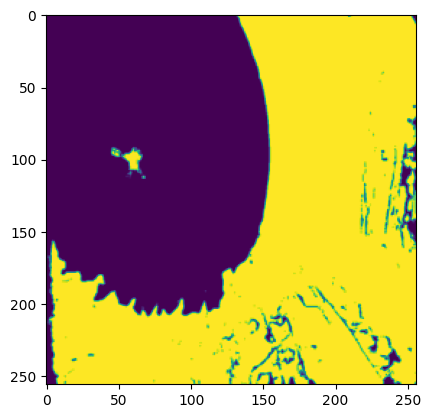

In [15]:
# Plot output frame 
plt.imshow(og_image)

tensor(0.8379, device='cuda:0', grad_fn=<MaxBackward1>)

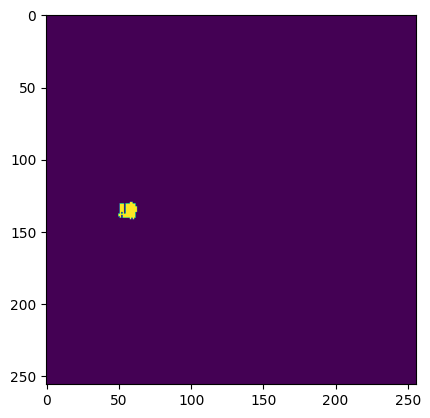

In [16]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32) 
plt.imshow(out[0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

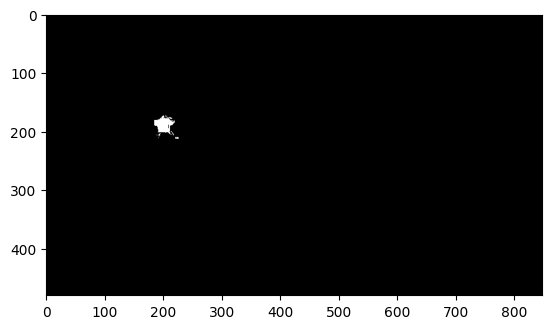

In [17]:
# Actual gt 
path_to_sequence = 'processed_flow/test3/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

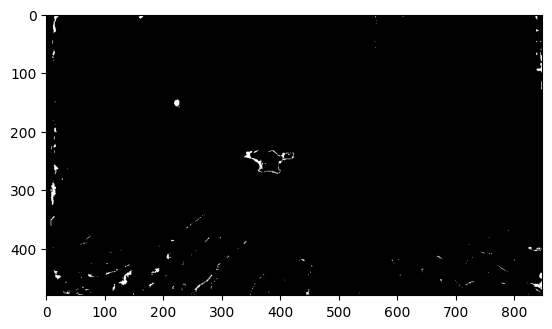

In [18]:
# Actual gt 
path_to_sequence = 'processed_flow/test1/inputs'
sequence_start = 1500
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

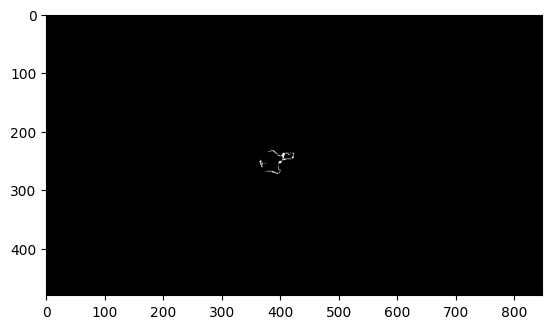

In [19]:
# Actual gt 
path_to_sequence = 'processed_flow/test1/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

#### Testing dataloader

In [20]:
batch_size = 1
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 1:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
in_frame = datapoint['input'][0][0, -1, 0, :, :]
out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

100%|██████████| 7/7 [00:00<00:00, 65.19it/s]


In [21]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')



Batched image shape should be: [(1, 5, 1, 256, 256)] and is: torch.Size([1, 5, 1, 256, 256])


tensor(0.6175)


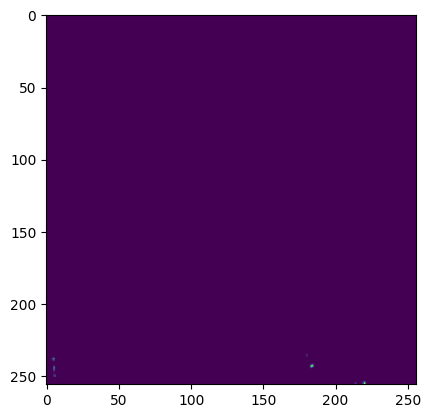

In [22]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(0.)


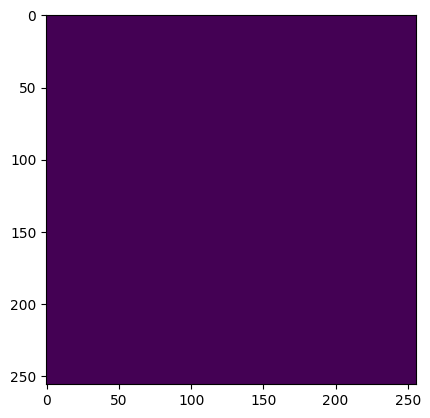

In [23]:
print(out_frame.max())
plt.imshow(out_frame)

In [24]:
features[0].shape
counter

KeyError: 0

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

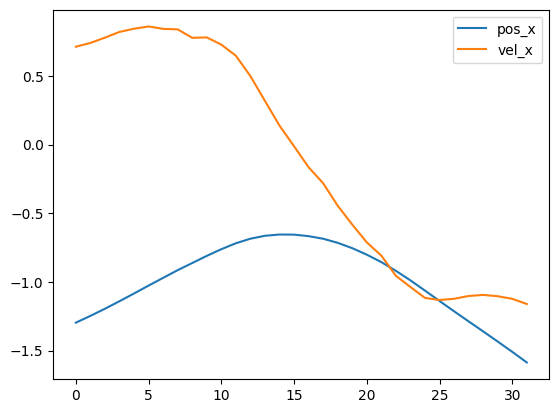

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

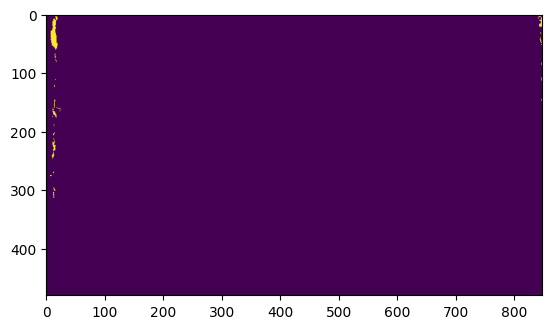

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])